In [1]:
import numpy as np
import scipy as sp
import cvxpy as cp

from models import ExampleModel
from methods import intermediate, salim, TrackingADMM, DPMM
from utils import plot_logs, plot_logs_pd

from typing import List

from tqdm import tqdm
from matplotlib import pyplot as plt

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

# Numerical Experiment

There we will use a model from Example 2 in paper ["Decentralized Proximal Method of Multipliers for Convex Optimization with Coupled Constraints", 2023](https://arxiv.org/pdf/2310.15596.pdf), but with L2 borm instead of L1, universal regularization parameter for all nodes, without right part of equality constraints and without inequality constraints.

This problem is also similar to Example in paper ["Decentralized Strongly-Convex Optimization with Affine Constraints: Primal and Dual Approaches"](https://arxiv.org/pdf/2207.04555.pdf), but there are distinct variables on each node.

$$ \min_{\mathbf{x}} F(\mathbf{x}) = \sum\limits_{i=1}^{n} \Big( \frac{1}{2}\| C_i x_i - d_i \|_2^{2} + \frac{\theta}{2} \| x_i \|_2^2 \Big) $$
$$ \textrm{s.t.} \quad \sum\limits_{i=1}^{n} \left( A_i x_i - b_i \right) = 0 $$ 
We can calculate function, gradient and hessian using
$$ \mathbf{C} = \mathrm{diag}\left(C_1, \ldots, C_n \right), \quad \mathbf{d} = \mathrm{col}\left( d_1, \ldots, d_n \right) $$
as
$$ F(\mathbf{x}) = \frac{1}{2}\| \mathbf{C} \mathbf{x} - \mathbf{d} \|_2^{2} + \frac{\theta}{2} \| \mathbf{x} \|_2^2 $$
$$ \nabla F(\mathbf{x}) = \mathbf{C}^\top \mathbf{C} \mathbf{x} - \mathbf{C}^\top \mathbf{d} + \theta \mathbf{x} $$
$$ \nabla^2 F(\mathbf{x}) = \mathbf{C}^\top \mathbf{C} + \theta I_{d} $$

# Khamisov reformulation + Augmentation

In [2]:
num_nodes = 20
num_cons = 3
dims = [3 for _ in range(num_nodes)]
graph = 'erdos-renyi'

## Intermediate algorithm

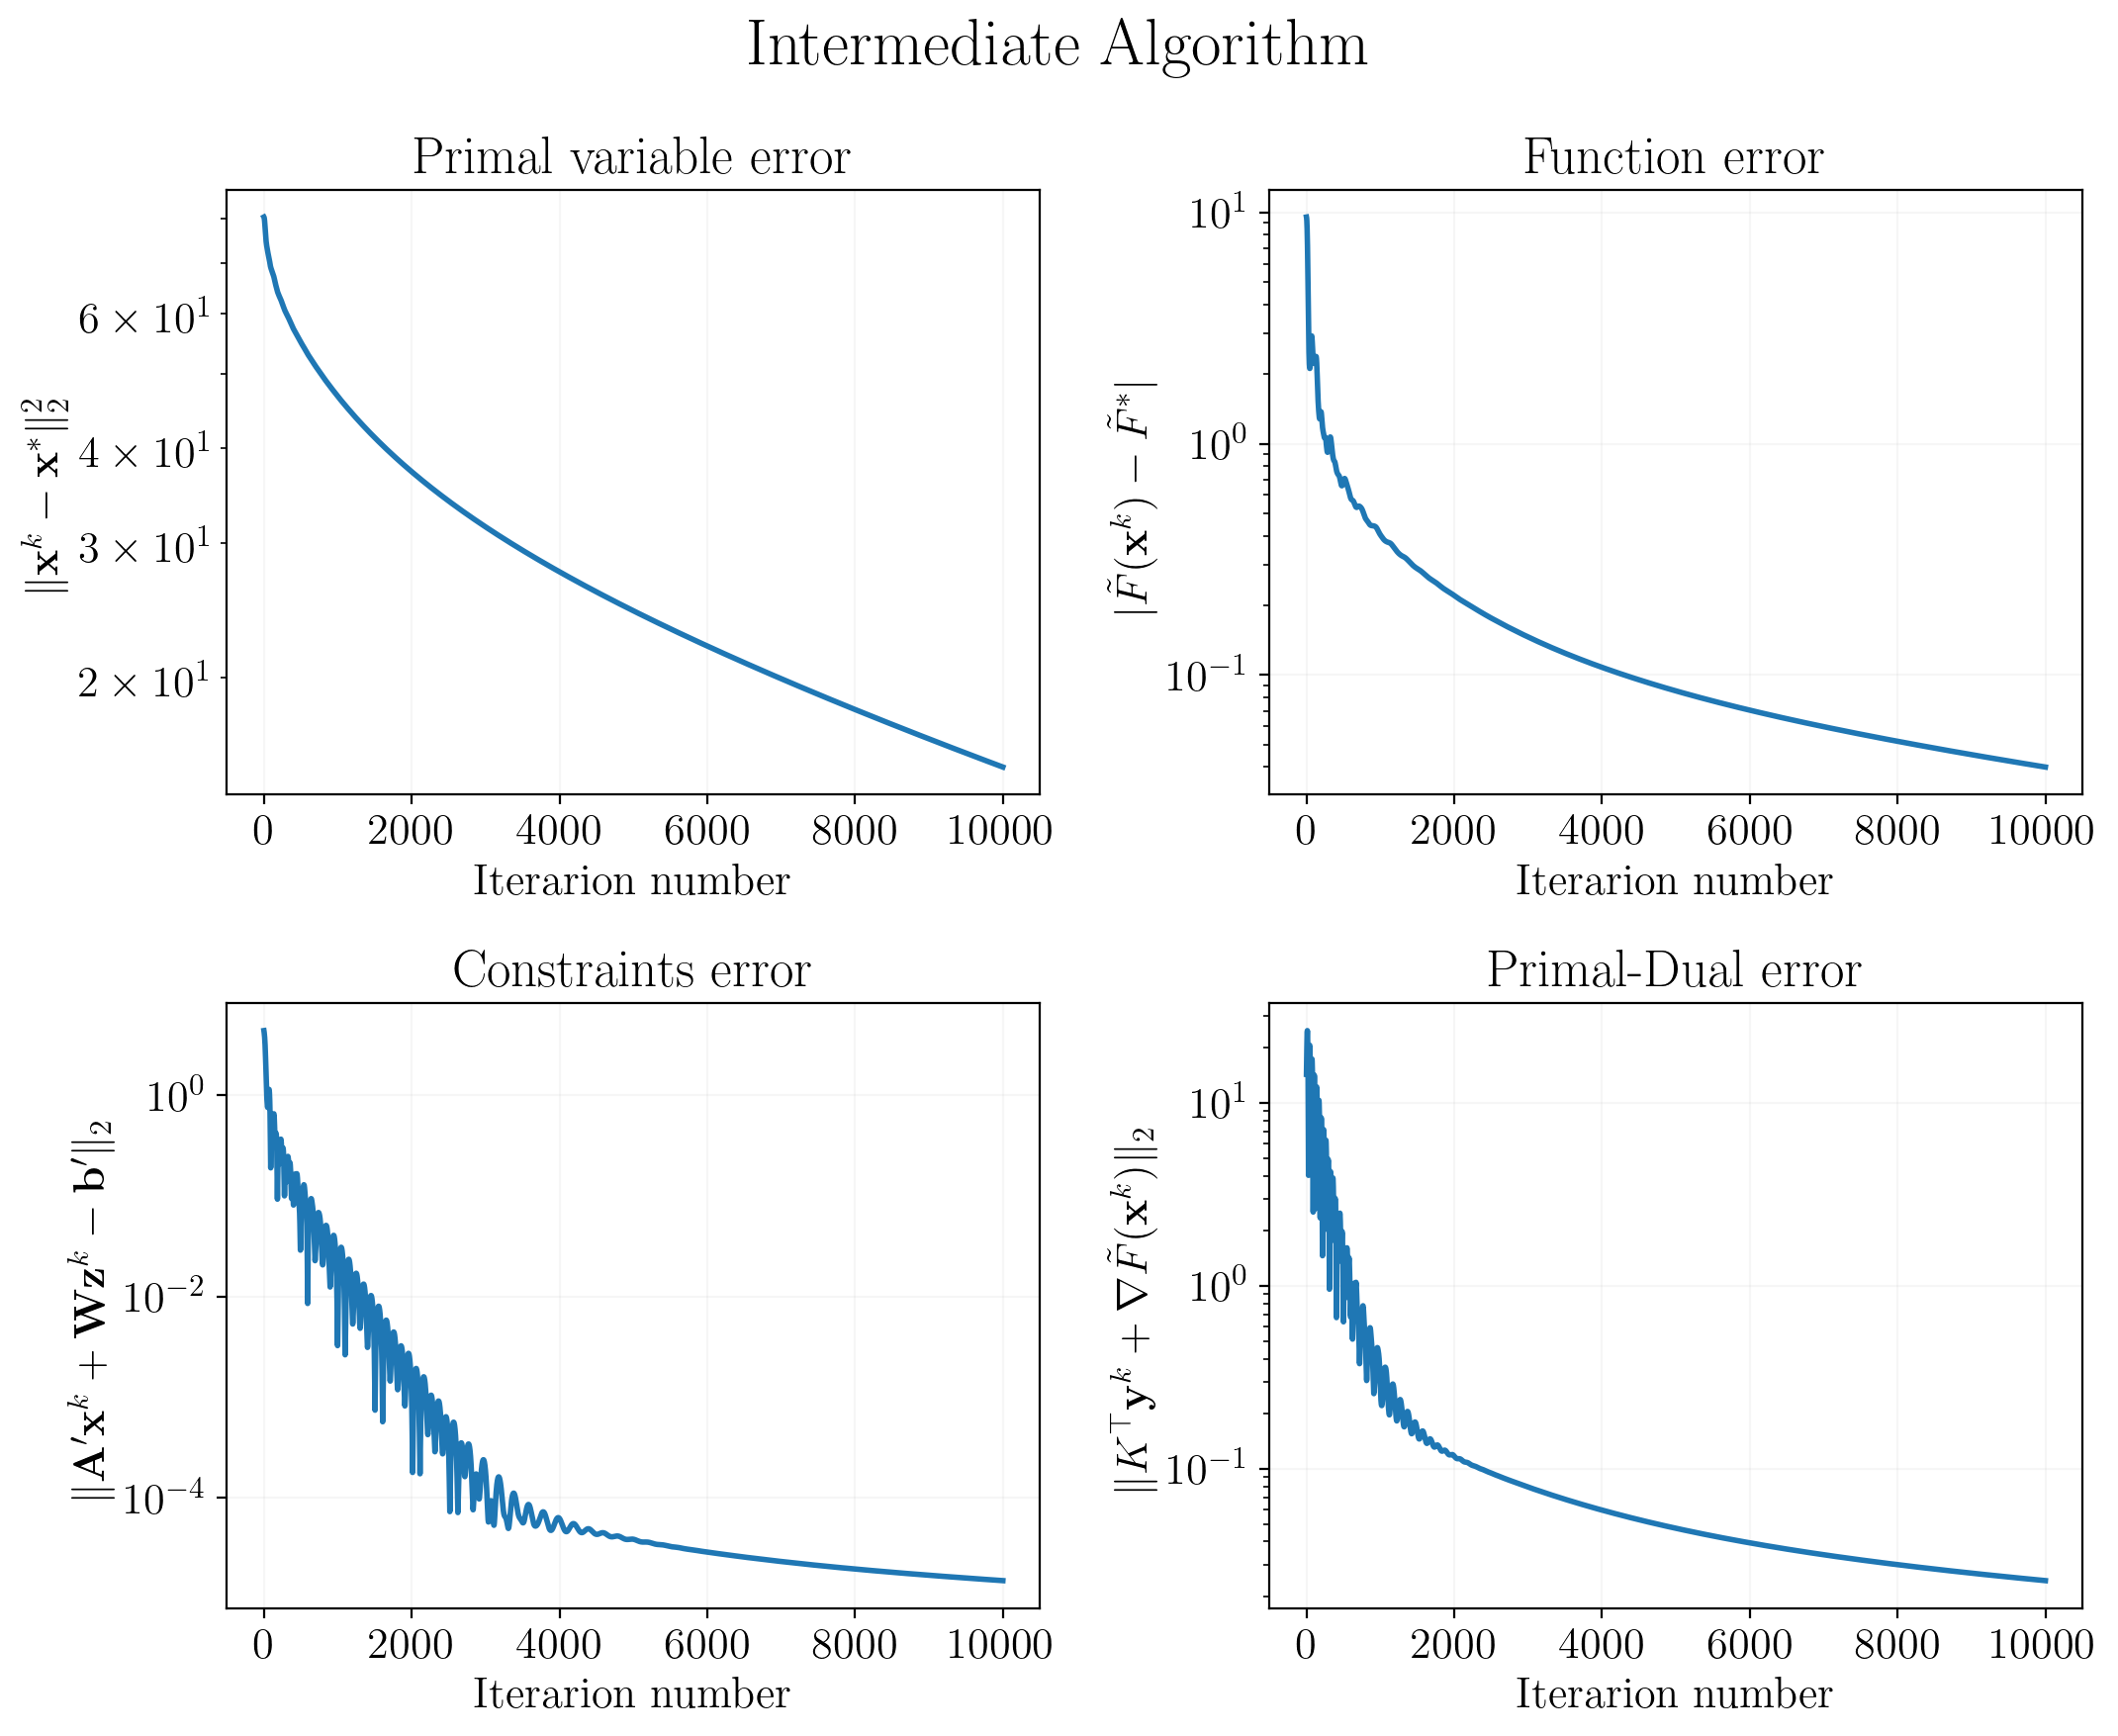

In [3]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=False)
x_f, x_err, F_err, cons_err, primal_dual_err = intermediate(num_steps=10**4, model=model)
plot_logs_pd(x_err, F_err, cons_err, primal_dual_err, "Intermediate Algorithm")

We can vary the value of `model.mu` to see, how sensitive is the method to the choice of a strong convexity constant

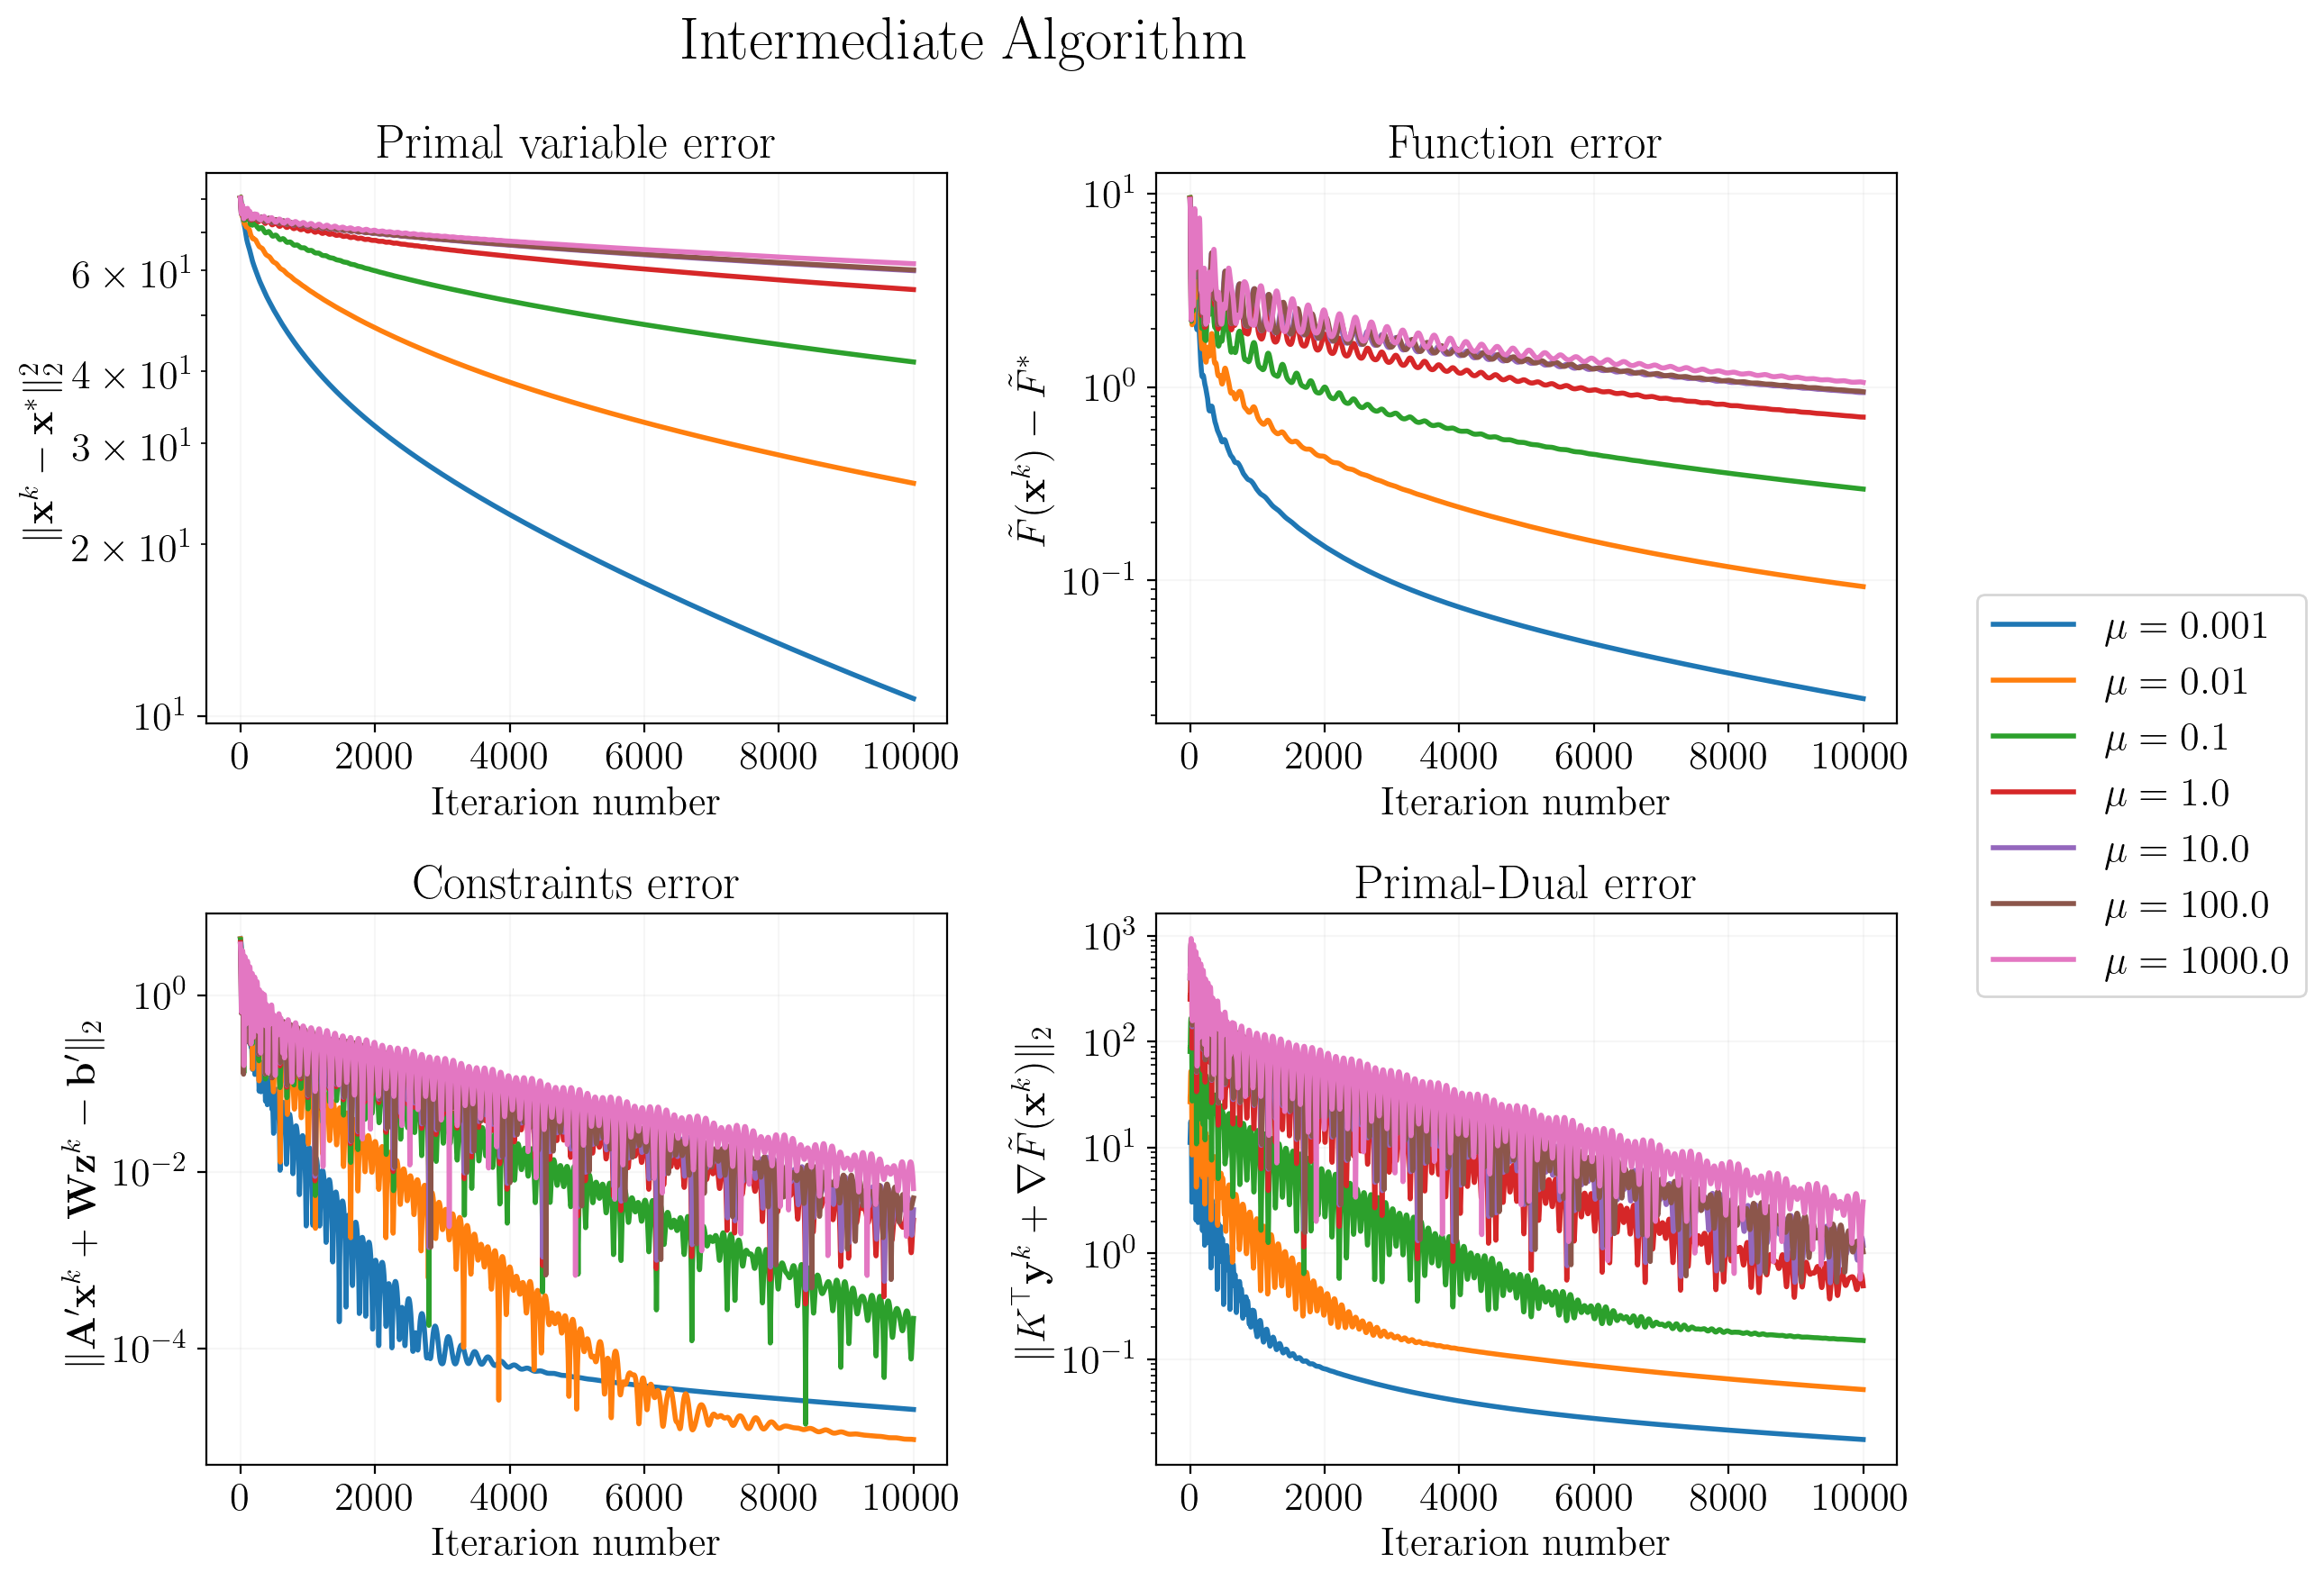

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(11, 9))

for mu in np.logspace(-3, int(np.log10(model.L)), 7):
    model._mu = mu
    #model._nu = mu
    model._kappa = model._L / model._mu
    x_f, x_err, F_err, cons_err, primal_dual_err = intermediate(num_steps=10**4, model=model)
    # plot logs
    ax[0][0].plot(x_err, label=f"$\mu = {mu}$")
    ax[0][1].plot(F_err)
    ax[1][0].plot(cons_err)
    ax[1][1].plot(primal_dual_err)
    
ax[0][0].set_yscale('log')
ax[0][0].set_xlabel("Iterarion number")
ax[0][0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0][0].set_title("Primal variable error")

ax[0][1].set_yscale('log')
ax[0][1].set_xlabel("Iterarion number")
ax[0][1].set_ylabel(r"$\tilde{F}(\mathbf{x}^k) - \tilde{F}^*$")
ax[0][1].set_title("Function error")

ax[1][0].set_yscale('log')
ax[1][0].set_xlabel("Iterarion number")
ax[1][0].set_ylabel(r"$\| \mathbf{A}' \mathbf{x}^k + \mathbf{W} \mathbf{z}^k - \mathbf{b}' \|_2$")
ax[1][0].set_title("Constraints error")

ax[1][1].set_yscale('log')
ax[1][1].set_xlabel("Iterarion number")
ax[1][1].set_ylabel(r"$\| K^\top \mathbf{y}^k + \nabla \tilde{F}(\mathbf{x}^k) \|_2$")
ax[1][1].set_title("Primal-Dual error")

fig.legend(bbox_to_anchor=(1, 0.5), loc="center left")

plt.suptitle("Intermediate Algorithm", fontsize=24)
plt.tight_layout()
plt.show()

We can use gossip matrix, created as $W = I - M$, where $M$ is mixing matrix by Metropolis weights

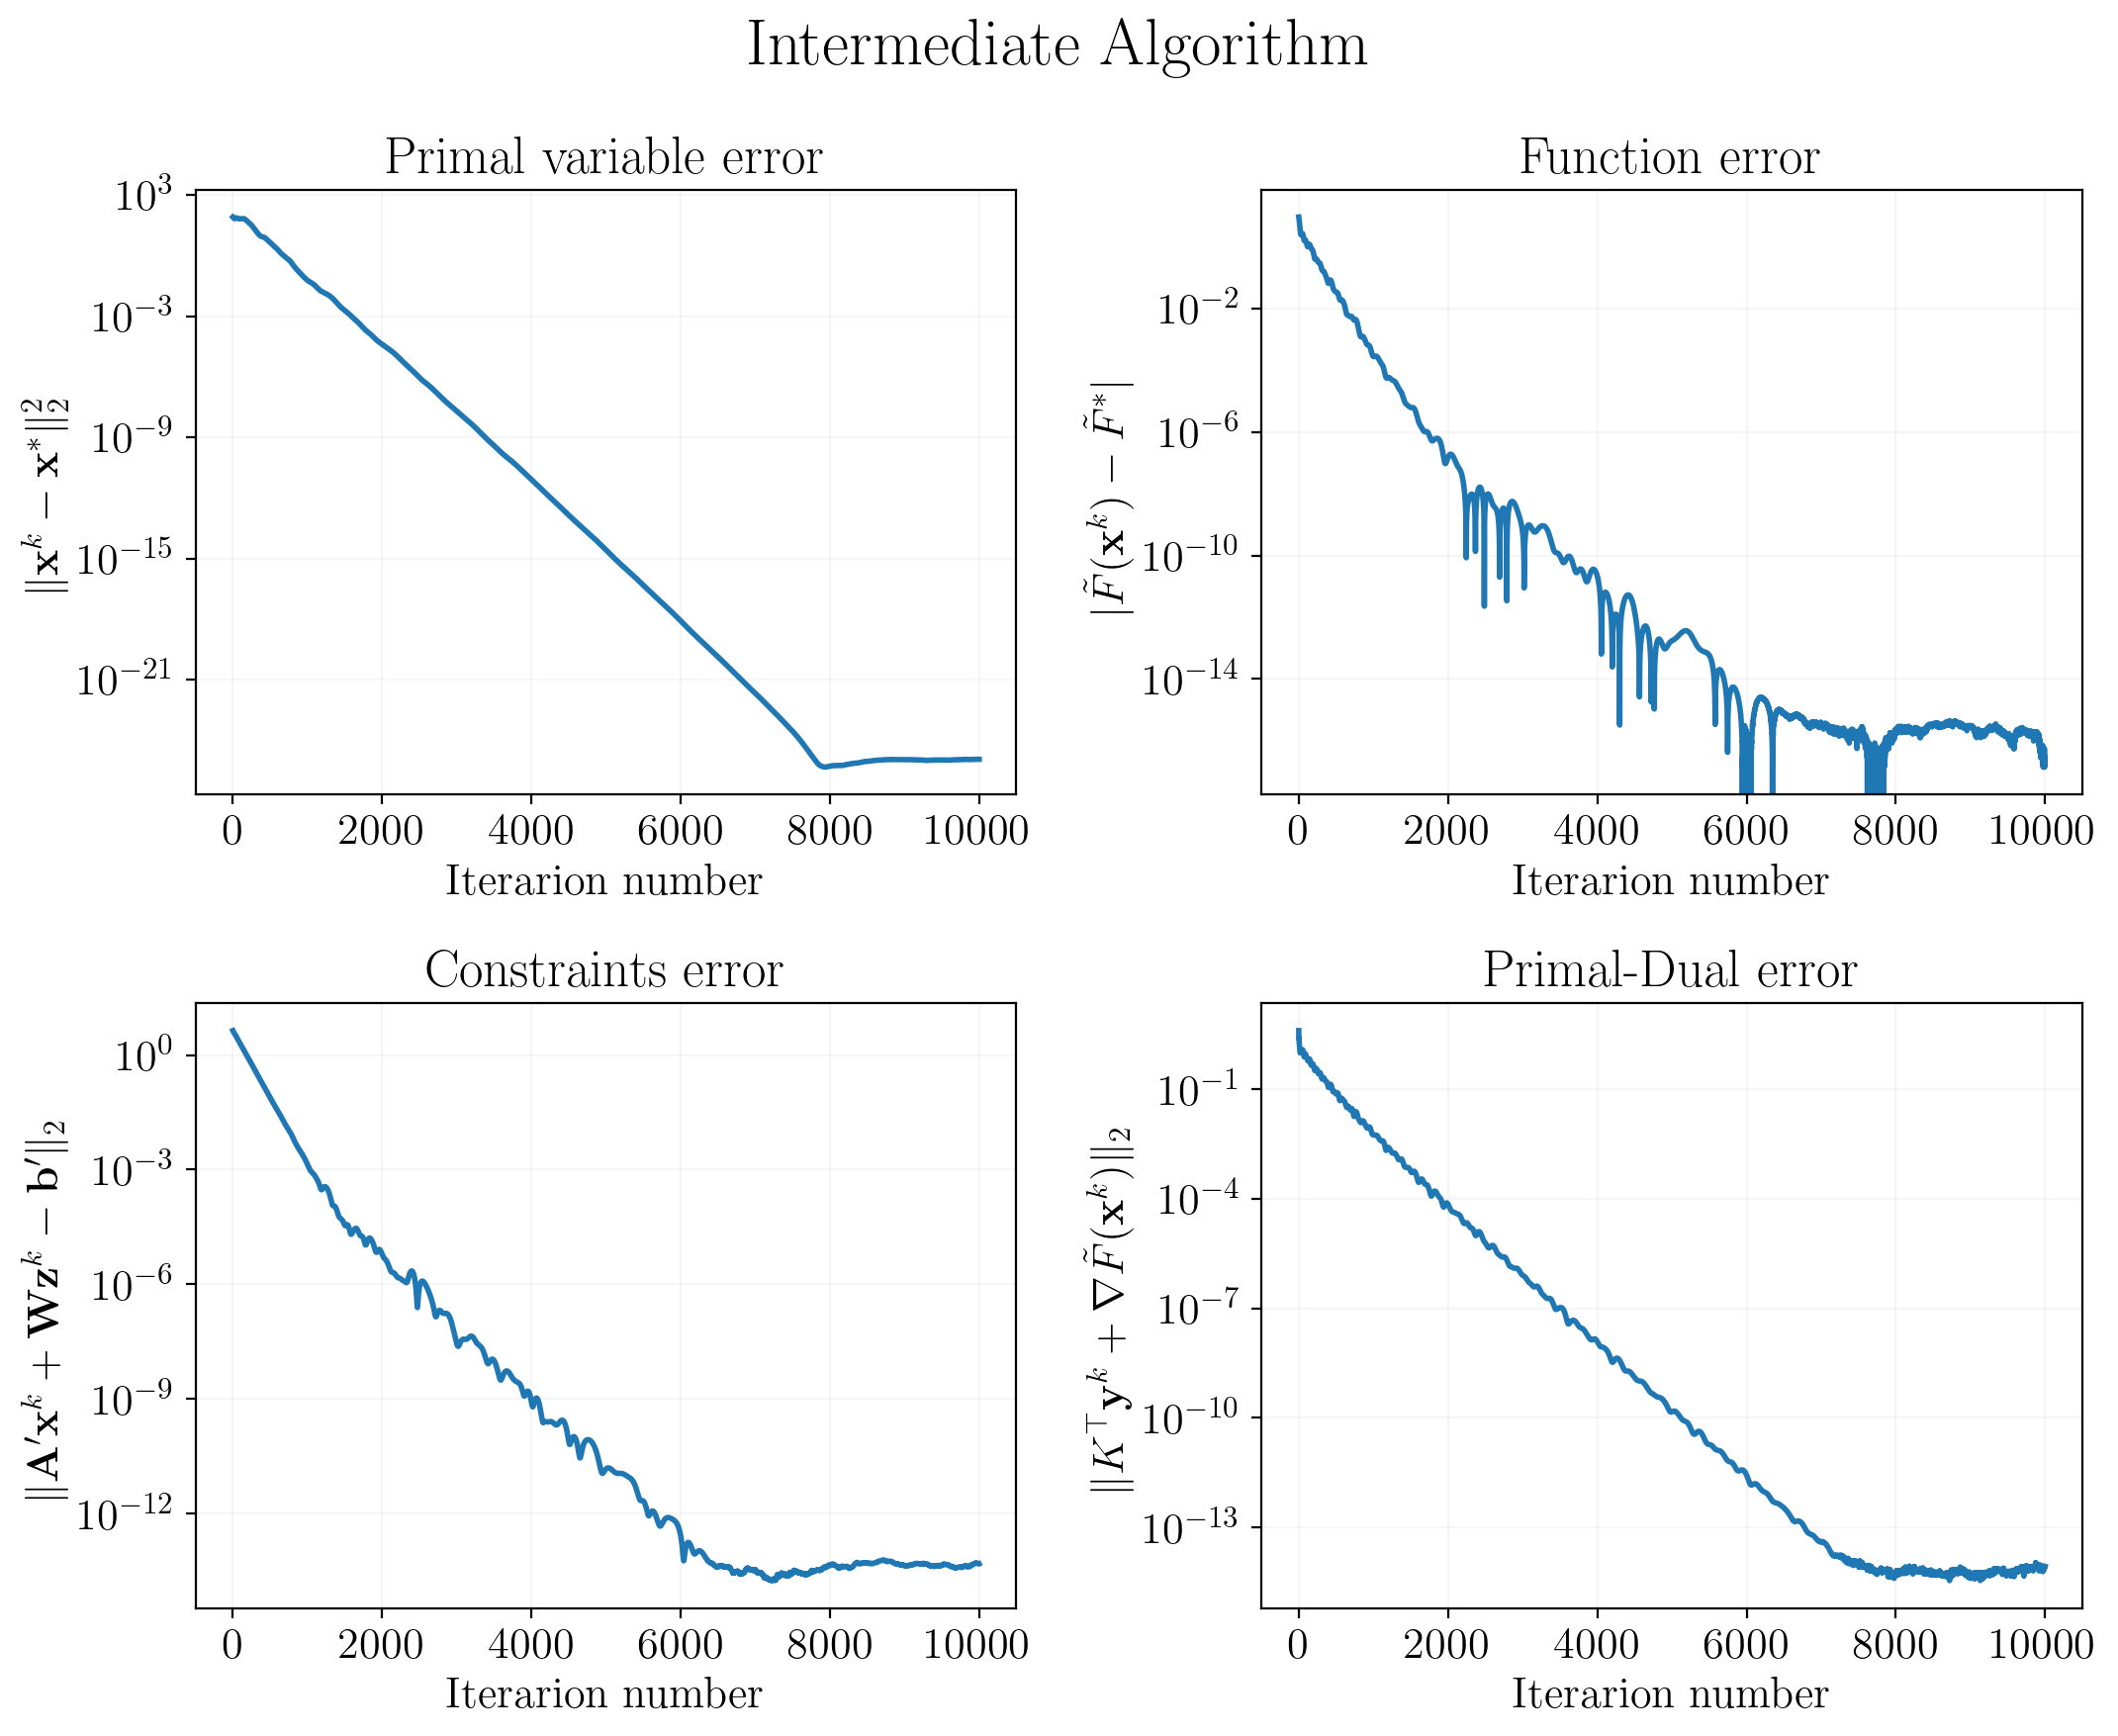

In [5]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=True)
x_f, x_err, F_err, cons_err, primal_dual_err = intermediate(num_steps=10**4, model=model)
plot_logs_pd(x_err, F_err, cons_err, primal_dual_err, "Intermediate Algorithm")

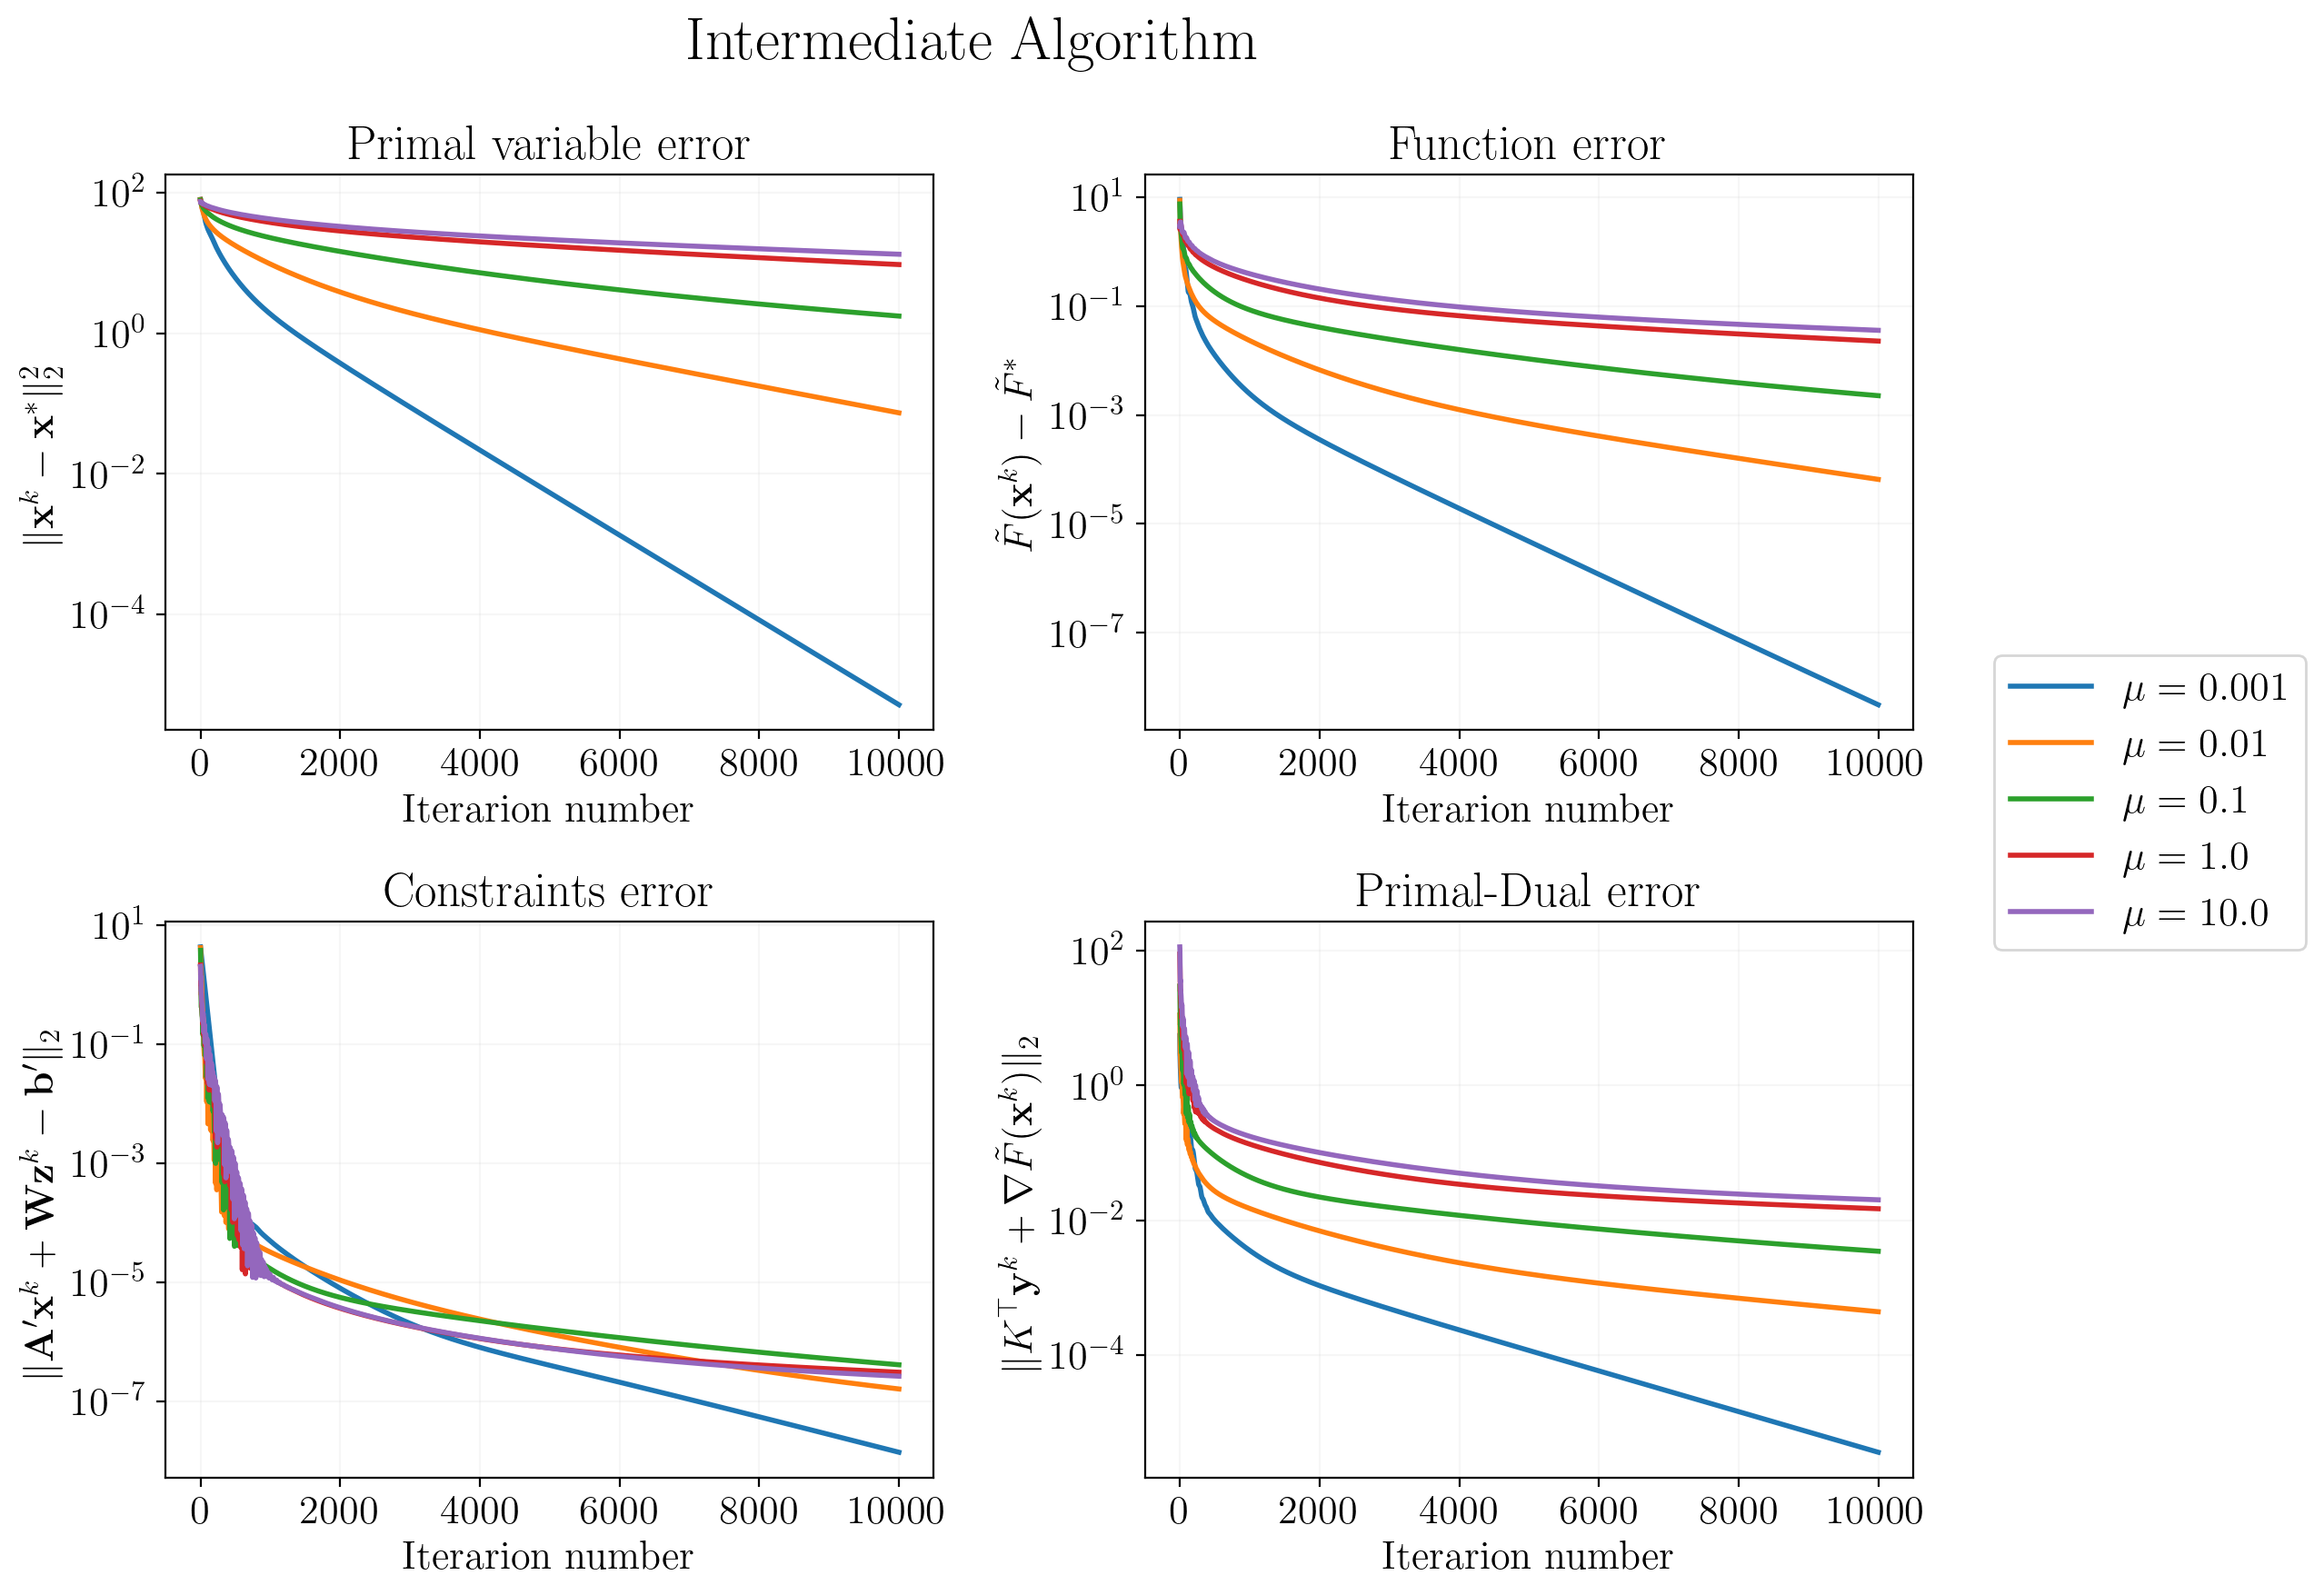

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(11, 9))

for mu in np.logspace(-3, int(np.log10(model.L)), 5):
    model._mu = mu
    #model._nu = mu
    model._kappa = model._L / model._mu
    x_f, x_err, F_err, cons_err, primal_dual_err = intermediate(num_steps=10**4, model=model)
    # plot logs
    ax[0][0].plot(x_err, label=f"$\mu = {mu}$")
    ax[0][1].plot(F_err)
    ax[1][0].plot(cons_err)
    ax[1][1].plot(primal_dual_err)
    
ax[0][0].set_yscale('log')
ax[0][0].set_xlabel("Iterarion number")
ax[0][0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0][0].set_title("Primal variable error")

ax[0][1].set_yscale('log')
ax[0][1].set_xlabel("Iterarion number")
ax[0][1].set_ylabel(r"$\tilde{F}(\mathbf{x}^k) - \tilde{F}^*$")
ax[0][1].set_title("Function error")

ax[1][0].set_yscale('log')
ax[1][0].set_xlabel("Iterarion number")
ax[1][0].set_ylabel(r"$\| \mathbf{A}' \mathbf{x}^k + \mathbf{W} \mathbf{z}^k - \mathbf{b}' \|_2$")
ax[1][0].set_title("Constraints error")

ax[1][1].set_yscale('log')
ax[1][1].set_xlabel("Iterarion number")
ax[1][1].set_ylabel(r"$\| K^\top \mathbf{y}^k + \nabla \tilde{F}(\mathbf{x}^k) \|_2$")
ax[1][1].set_title("Primal-Dual error")

fig.legend(bbox_to_anchor=(1, 0.5), loc="center left")

plt.suptitle("Intermediate Algorithm", fontsize=24)
plt.tight_layout()
plt.show()

## Algorithm 1

With $W$ as Laplacian matrix of the communication graph

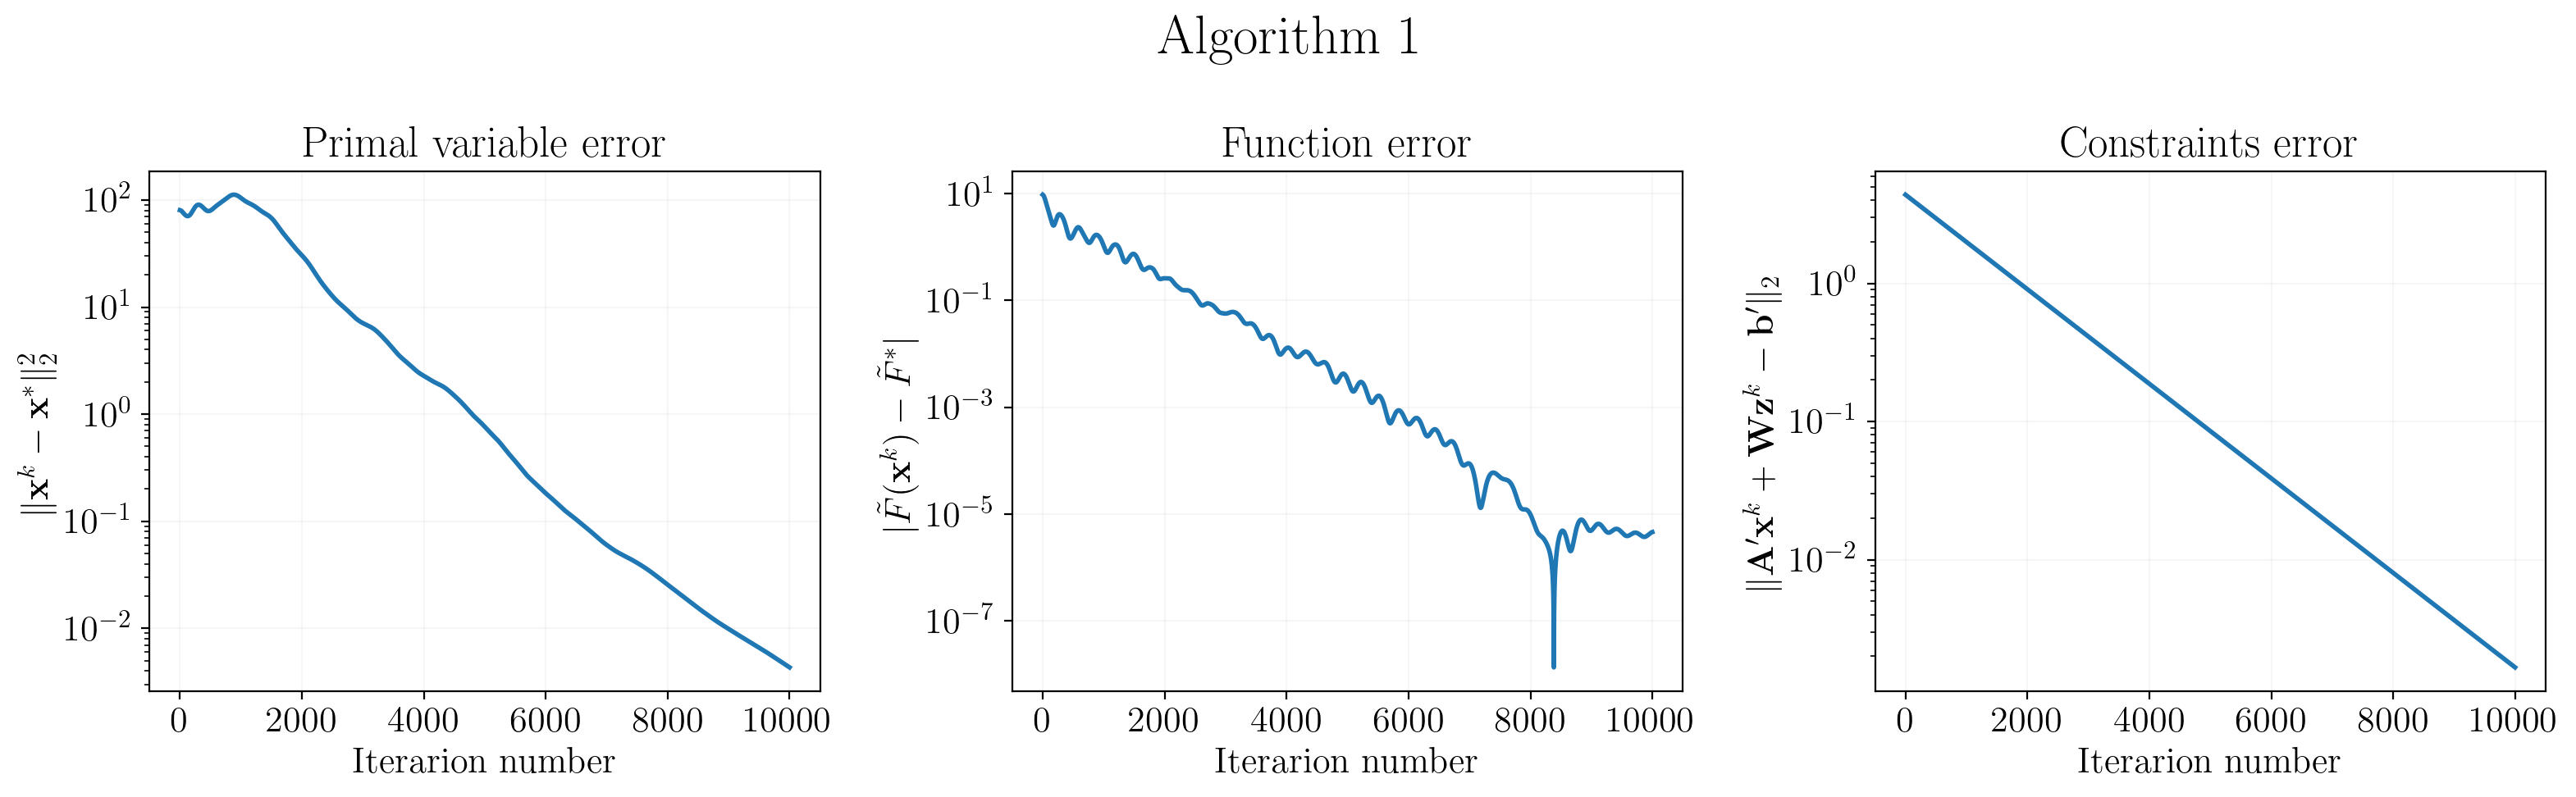

In [7]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=False)
x_f, x_err, F_err, cons_err = salim(num_steps=10**4, model=model)
plot_logs(x_err, F_err, cons_err, "Algorithm 1")

We can vary the value of `model.mu` to see, how sensitive is the method to the choice of a strong convexity constant

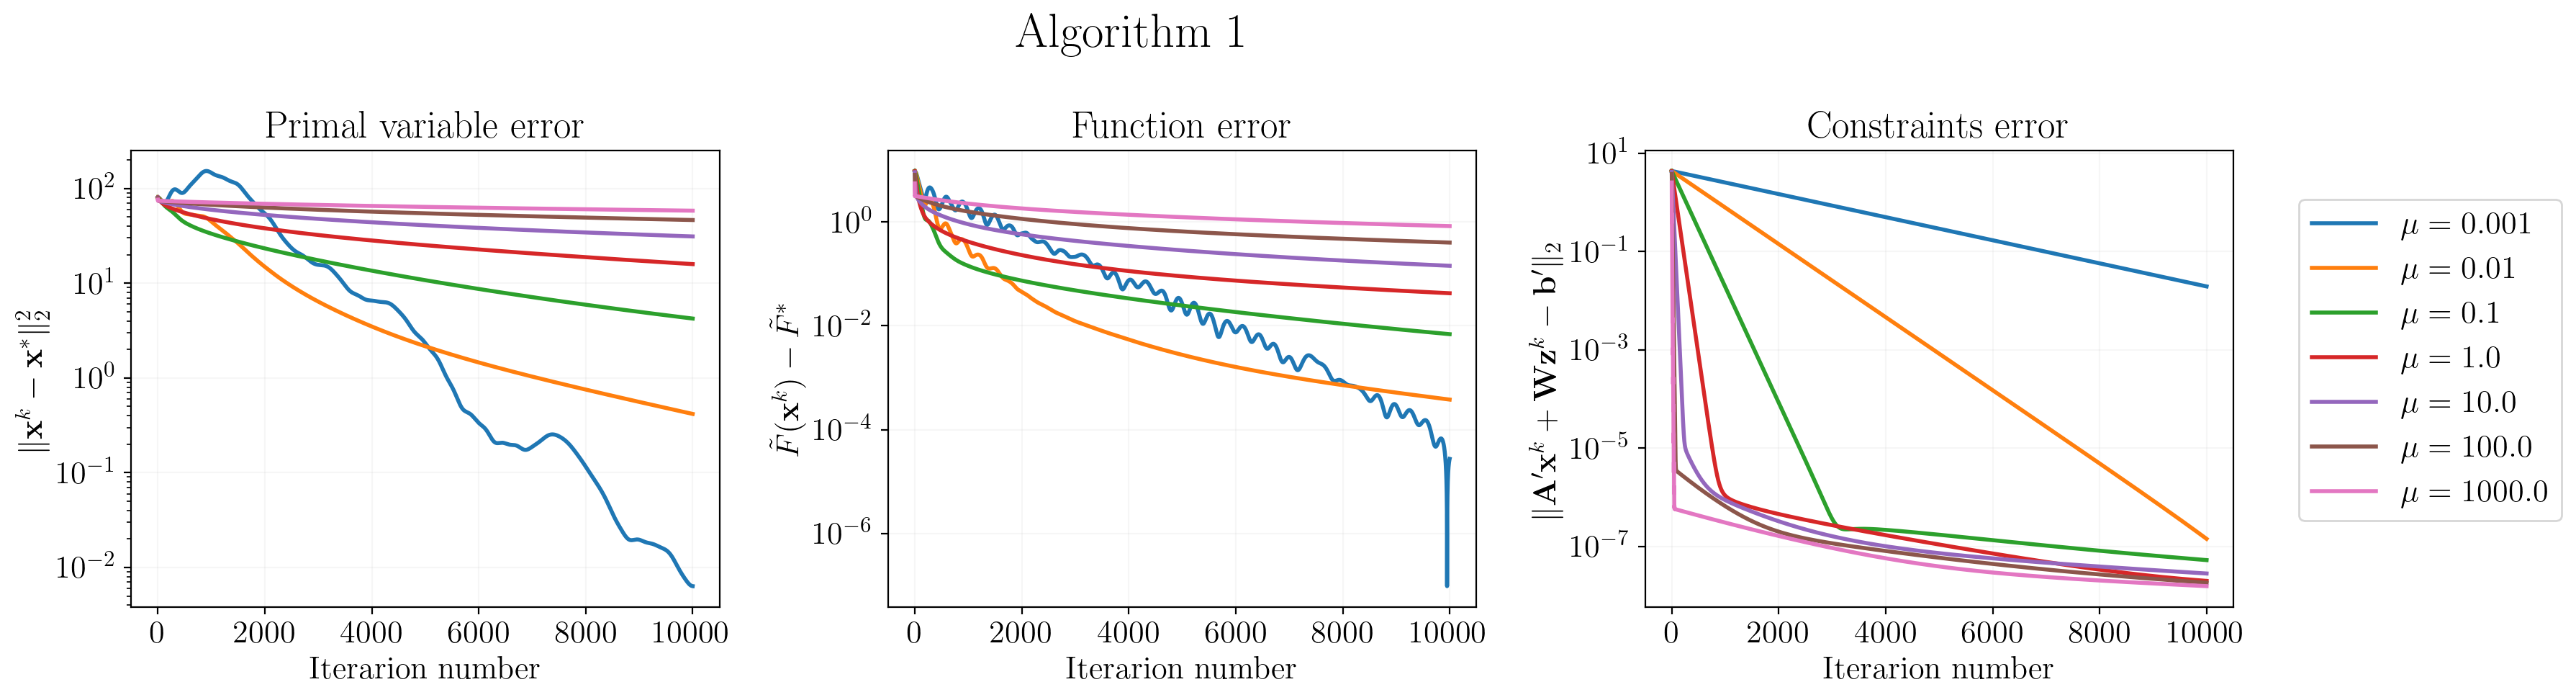

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for mu in np.logspace(-3, int(np.log10(model.L)), 7):
    model._mu = mu
    #model._nu = mu
    model._kappa = model._L / model._mu
    x_f, x_err, F_err, cons_err = salim(num_steps=10**4, model=model)
    # plot logs
    ax[0].plot(x_err, label=f"$\mu = {mu}$")
    ax[1].plot(F_err)
    ax[2].plot(cons_err)

ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$\tilde{F}(\mathbf{x}^k) - \tilde{F}^*$")
ax[1].set_title("Function error")

ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A}' \mathbf{x}^k + \mathbf{W} \mathbf{z}^k - \mathbf{b}' \|_2$")
ax[2].set_title("Constraints error")

fig.legend(bbox_to_anchor=(1, 0.5), loc="center left")

plt.suptitle("Algorithm 1", fontsize=24)
plt.tight_layout()
plt.show()

Take $W$ as gossip matrix by Metropolis weights

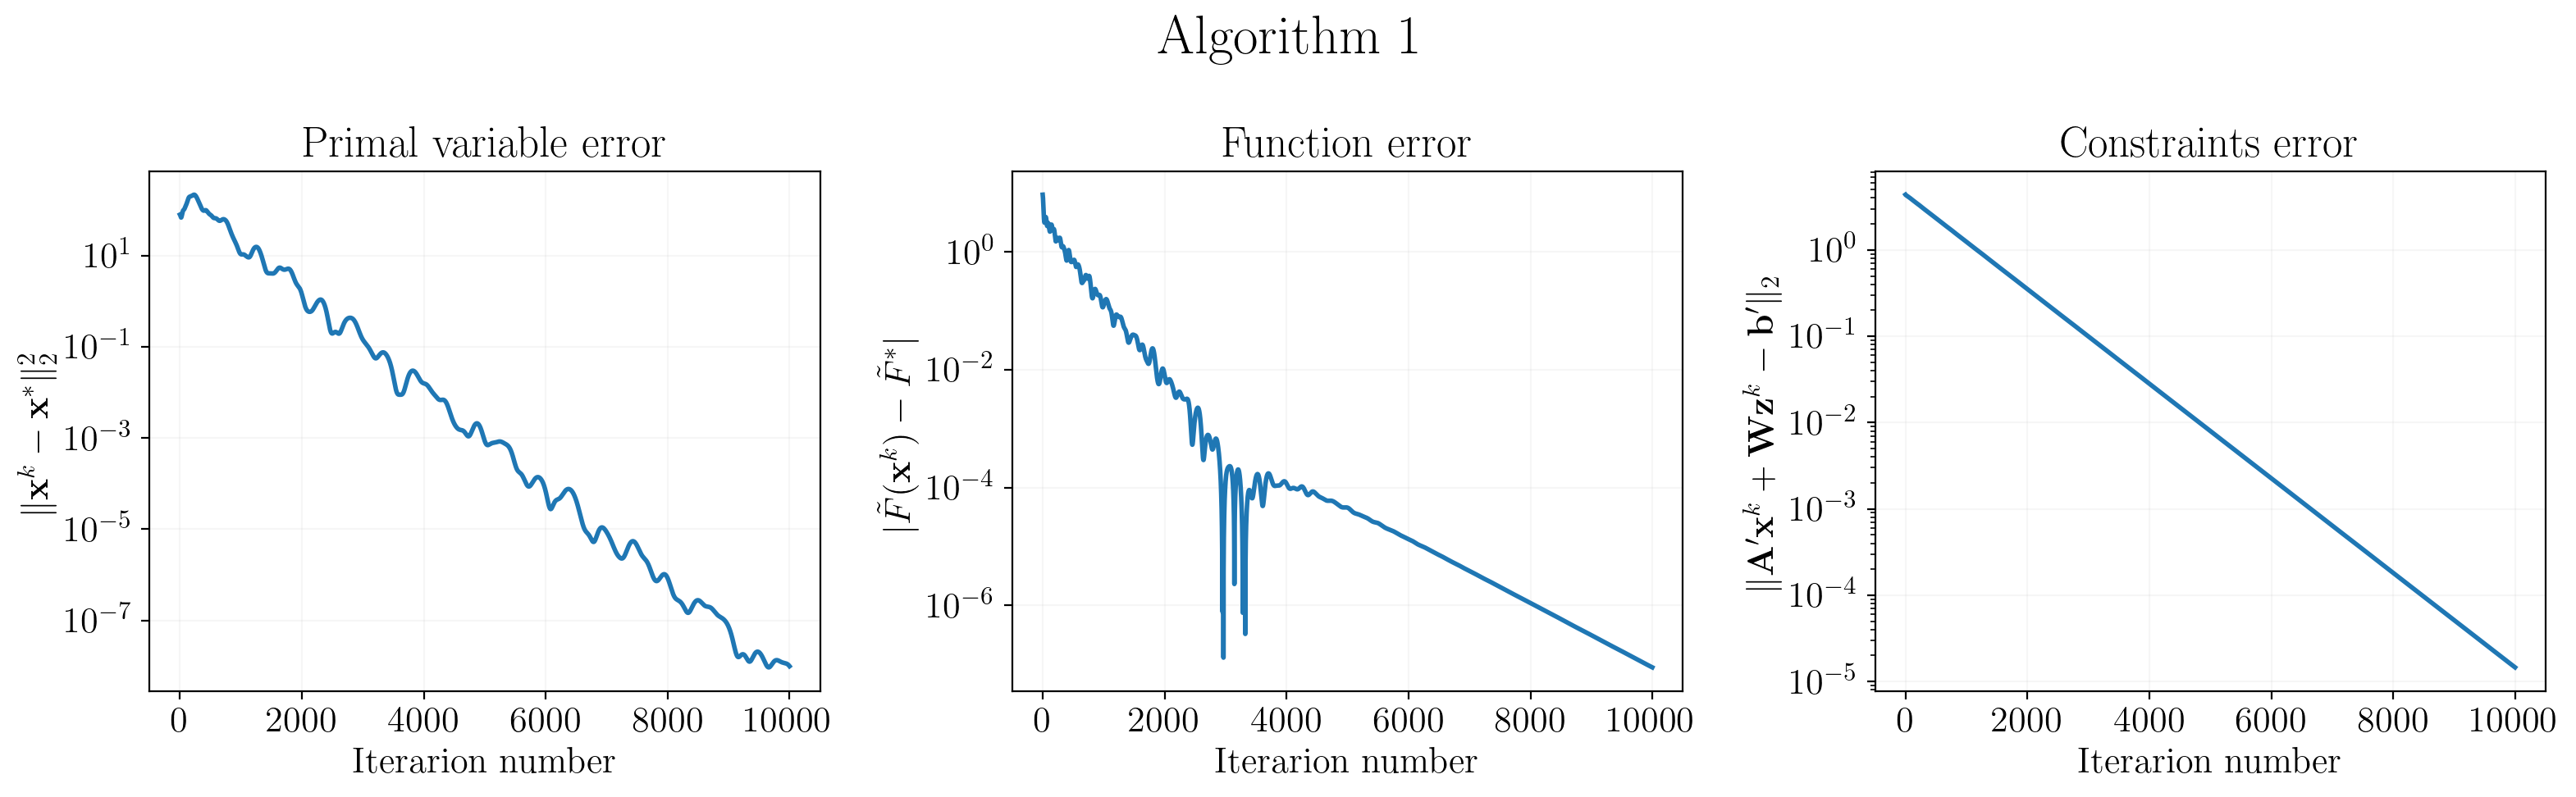

In [9]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=True)
x_f, x_err, F_err, cons_err = salim(num_steps=10**4, model=model)
plot_logs(x_err, F_err, cons_err, "Algorithm 1")

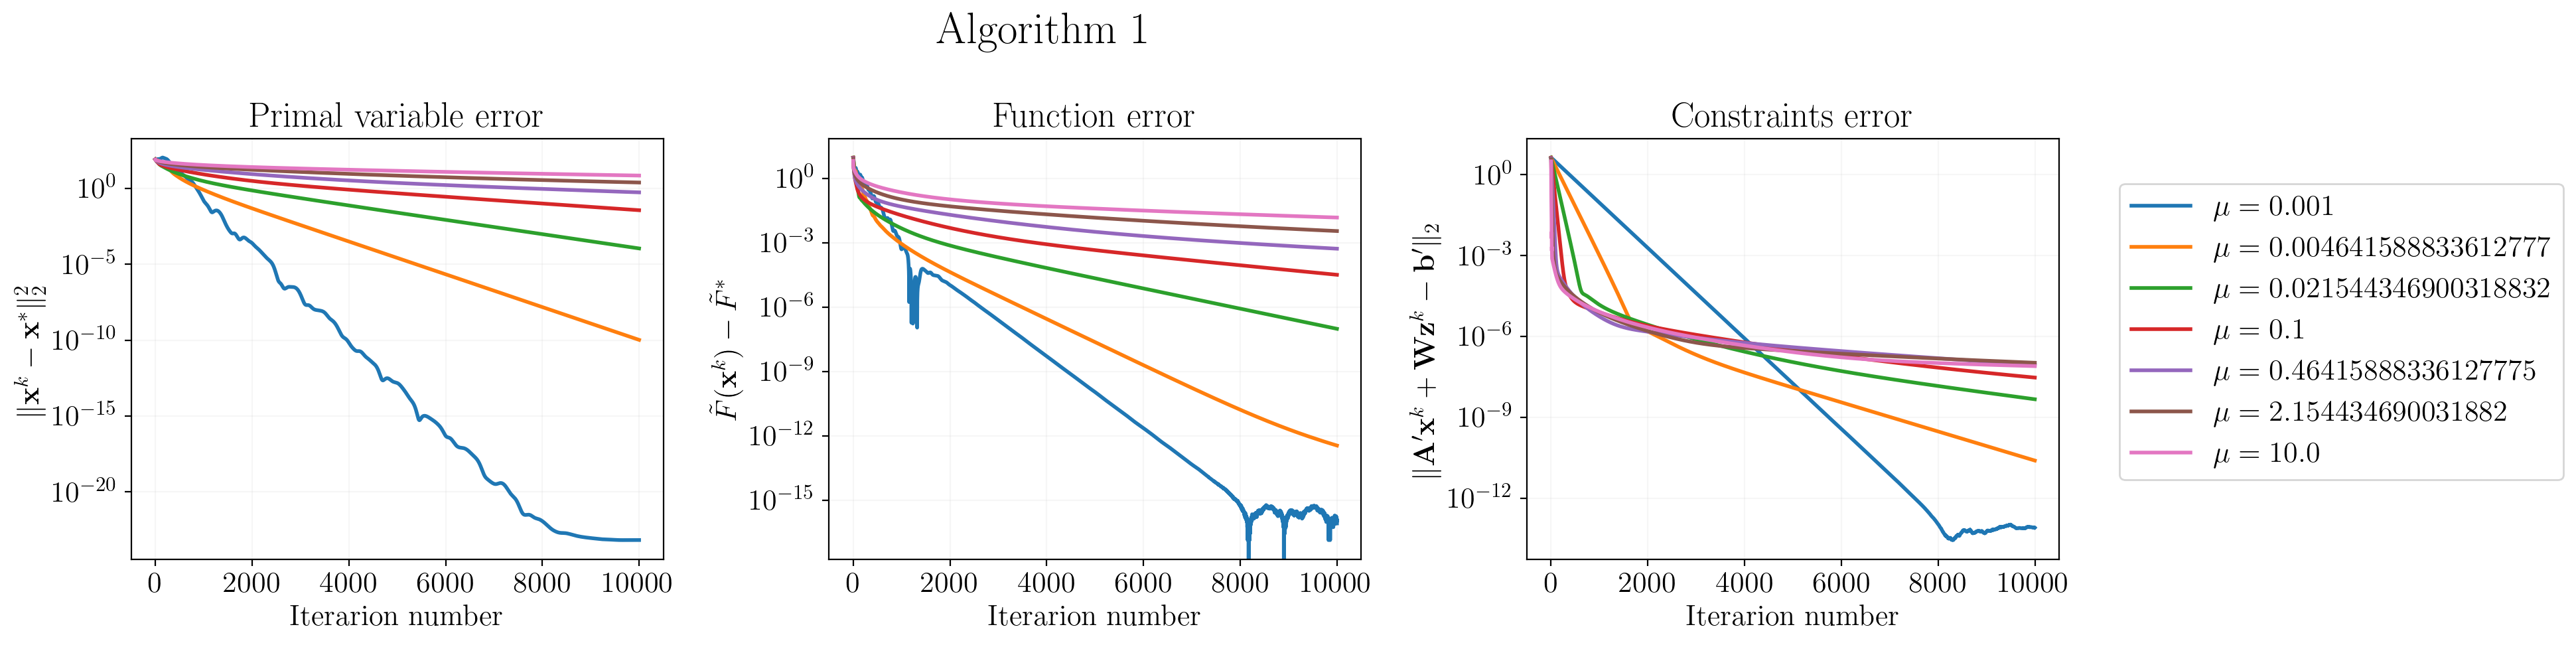

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for mu in np.logspace(-3, int(np.log10(model.L)), 7):
    model._mu = mu
    #model._nu = mu
    model._kappa = model._L / model._mu
    x_f, x_err, F_err, cons_err = salim(num_steps=10**4, model=model)
    # plot logs
    ax[0].plot(x_err, label=f"$\mu = {mu}$")
    ax[1].plot(F_err)
    ax[2].plot(cons_err)

ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$\tilde{F}(\mathbf{x}^k) - \tilde{F}^*$")
ax[1].set_title("Function error")

ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A}' \mathbf{x}^k + \mathbf{W} \mathbf{z}^k - \mathbf{b}' \|_2$")
ax[2].set_title("Constraints error")

fig.legend(bbox_to_anchor=(1, 0.5), loc="center left")

plt.suptitle("Algorithm 1", fontsize=24)
plt.tight_layout()
plt.show()

## Tracking-ADMM

In [11]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=False)
x, x_err, F_err, cons_err = TrackingADMM(num_steps=10**4, model=model, params={'c': 1e-6})

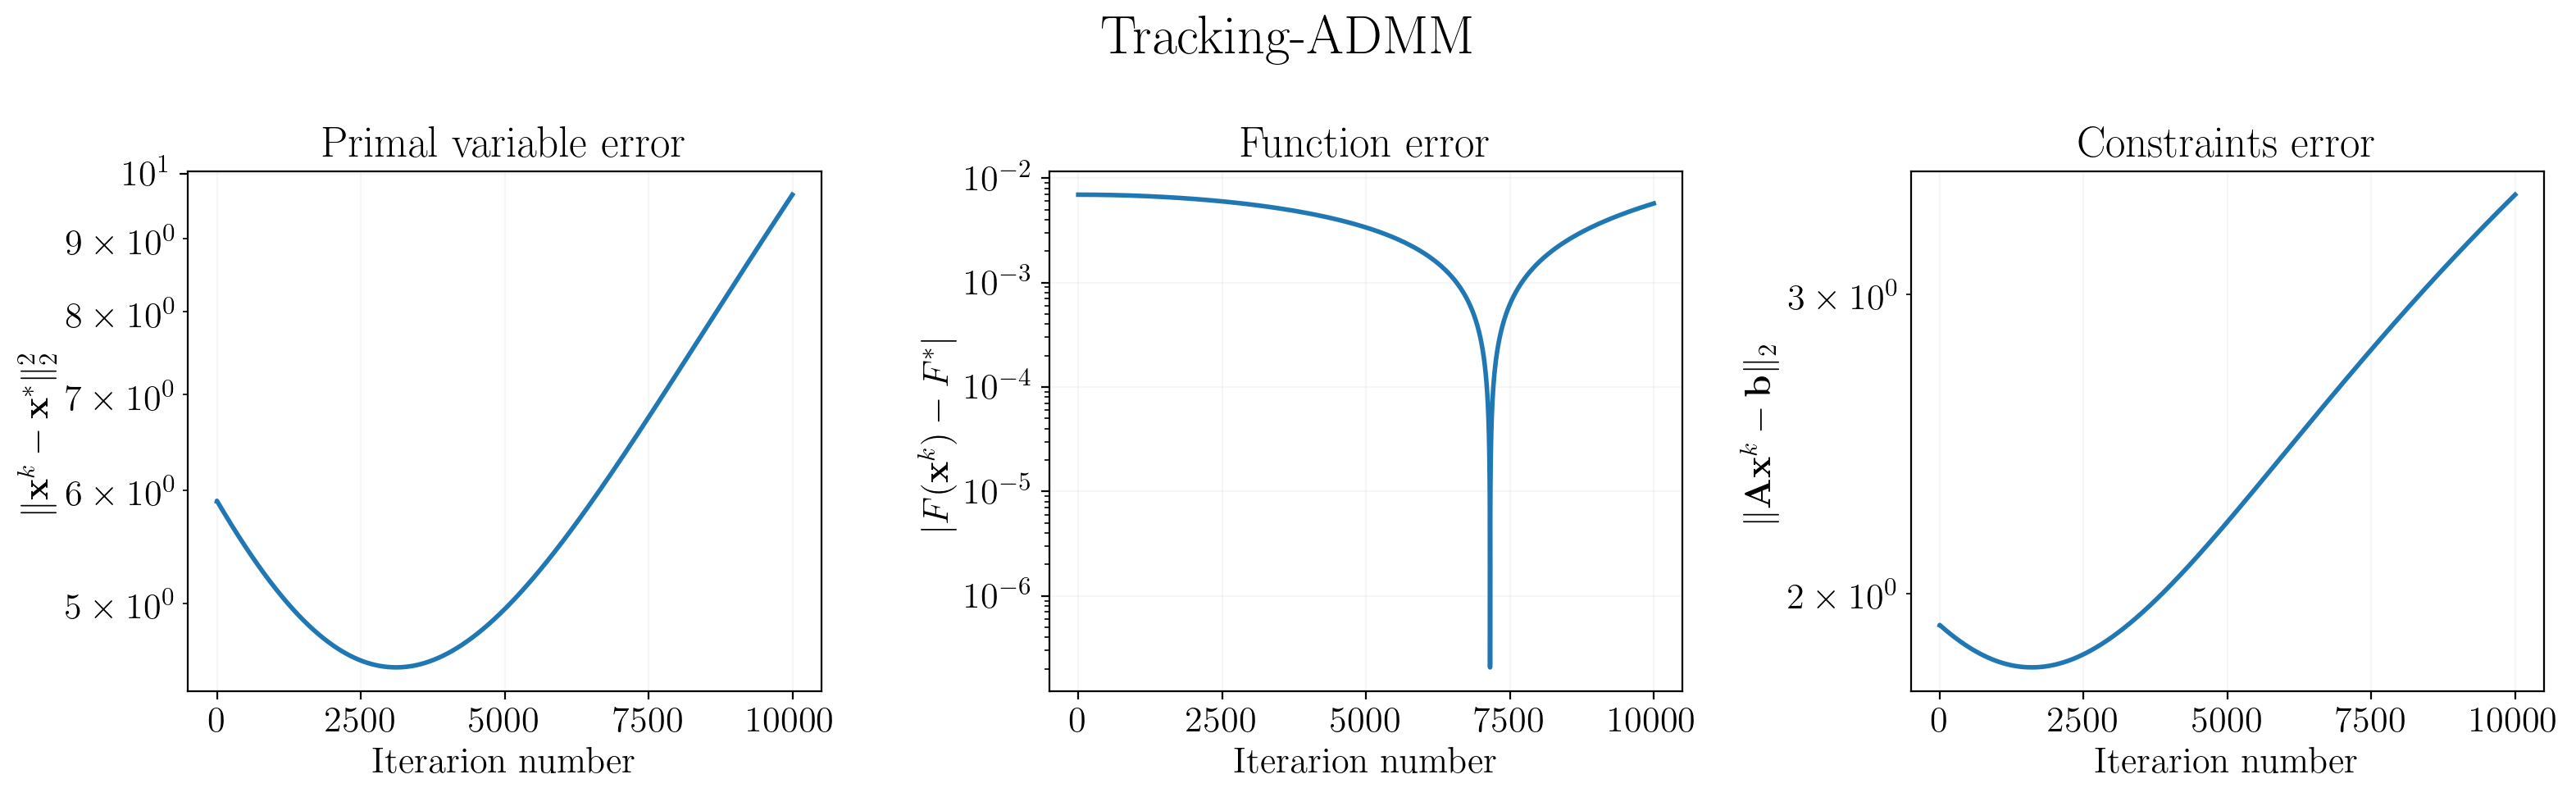

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(\mathbf{x}^k) - F^*|$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A} \mathbf{x}^k - \mathbf{b} \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle("Tracking-ADMM", fontsize=24)
plt.tight_layout()
plt.show()

And now with Metropolis weights crafted $W$

In [13]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=True)
x, x_err, F_err, cons_err = TrackingADMM(num_steps=10**4, model=model, params={'c': 1e-6})

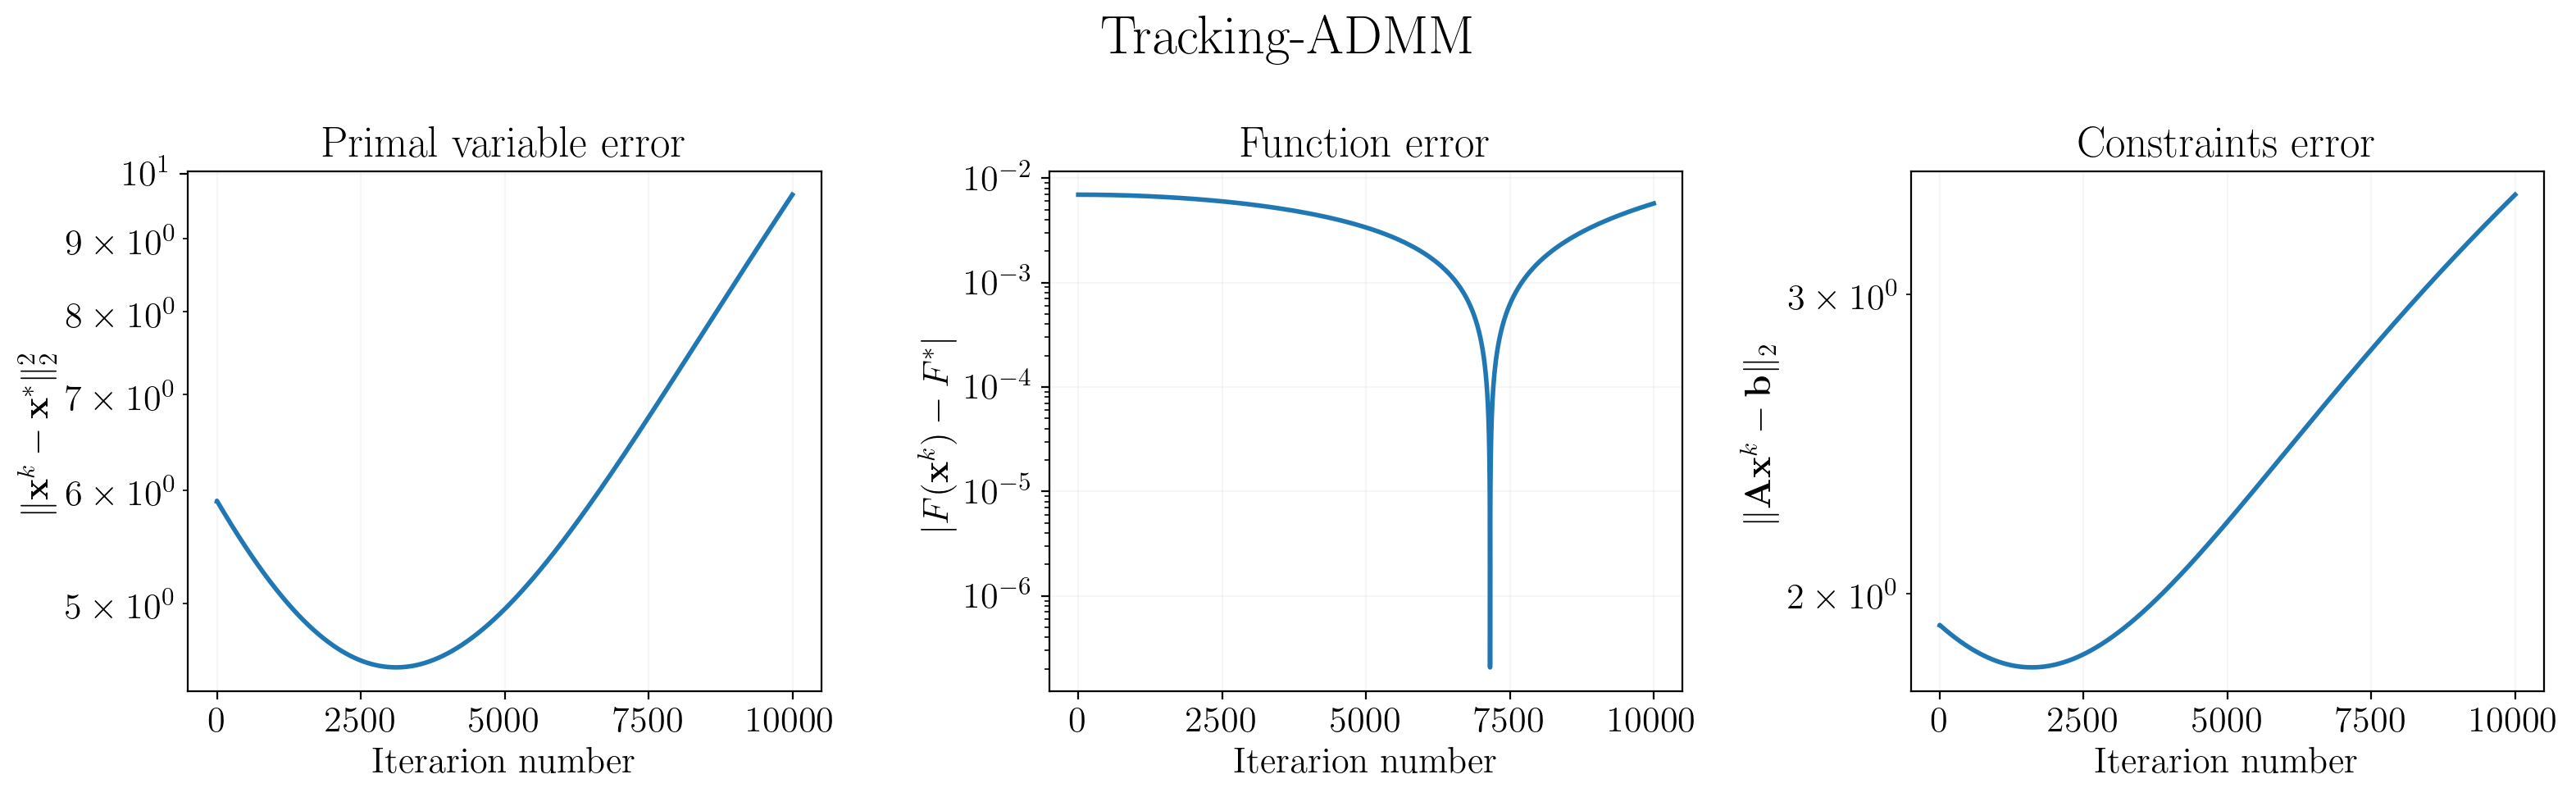

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(\mathbf{x}^k) - F^*|$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A} \mathbf{x}^k - \mathbf{b} \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle("Tracking-ADMM", fontsize=24)
plt.tight_layout()
plt.show()

## DPMM

In [15]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=False)
x, x_err, F_err, cons_err = DPMM(num_steps=10**4, model=model)

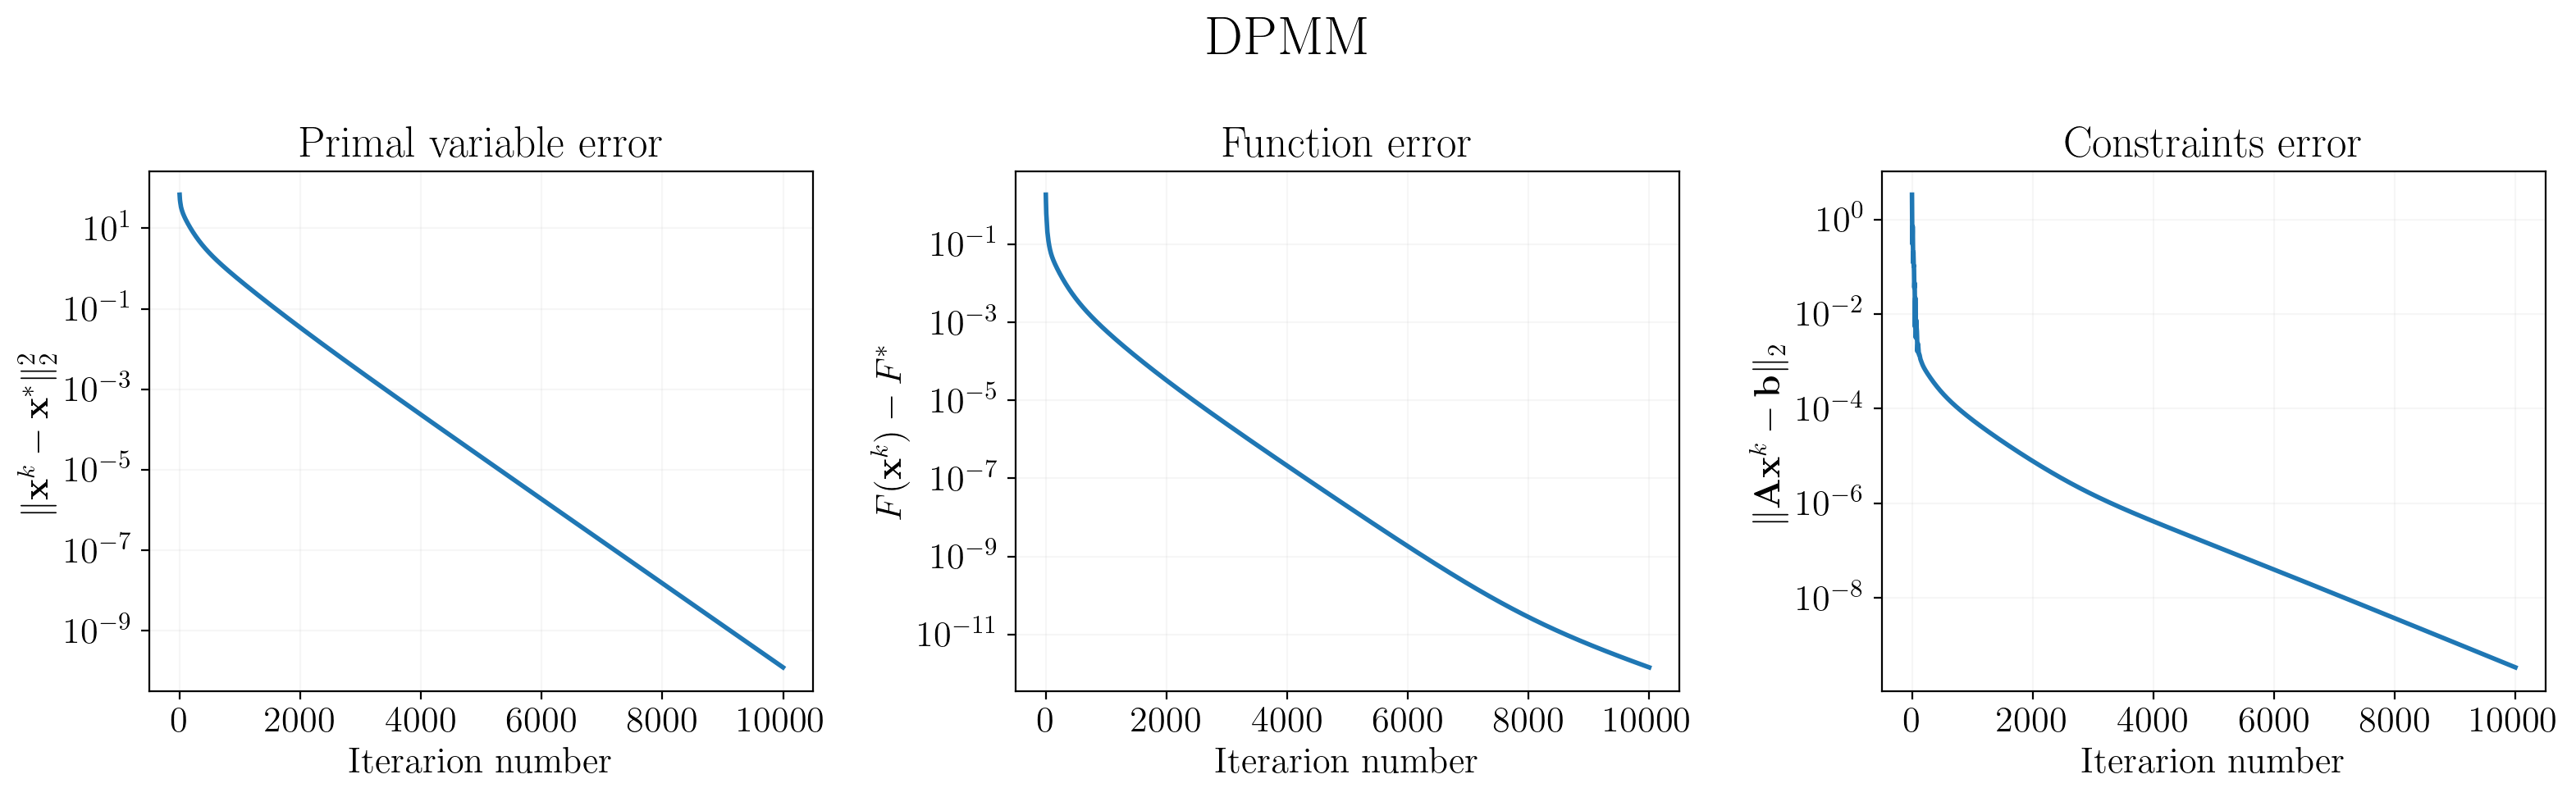

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$F(\mathbf{x}^k) - F^*$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A} \mathbf{x}^k - \mathbf{b} \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle("DPMM", fontsize=24)
plt.tight_layout()
plt.show()

Now let's use $W$ as crafted by Metropolis weights

In [17]:
np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=True)
x, x_err, F_err, cons_err = DPMM(num_steps=10**4, model=model)

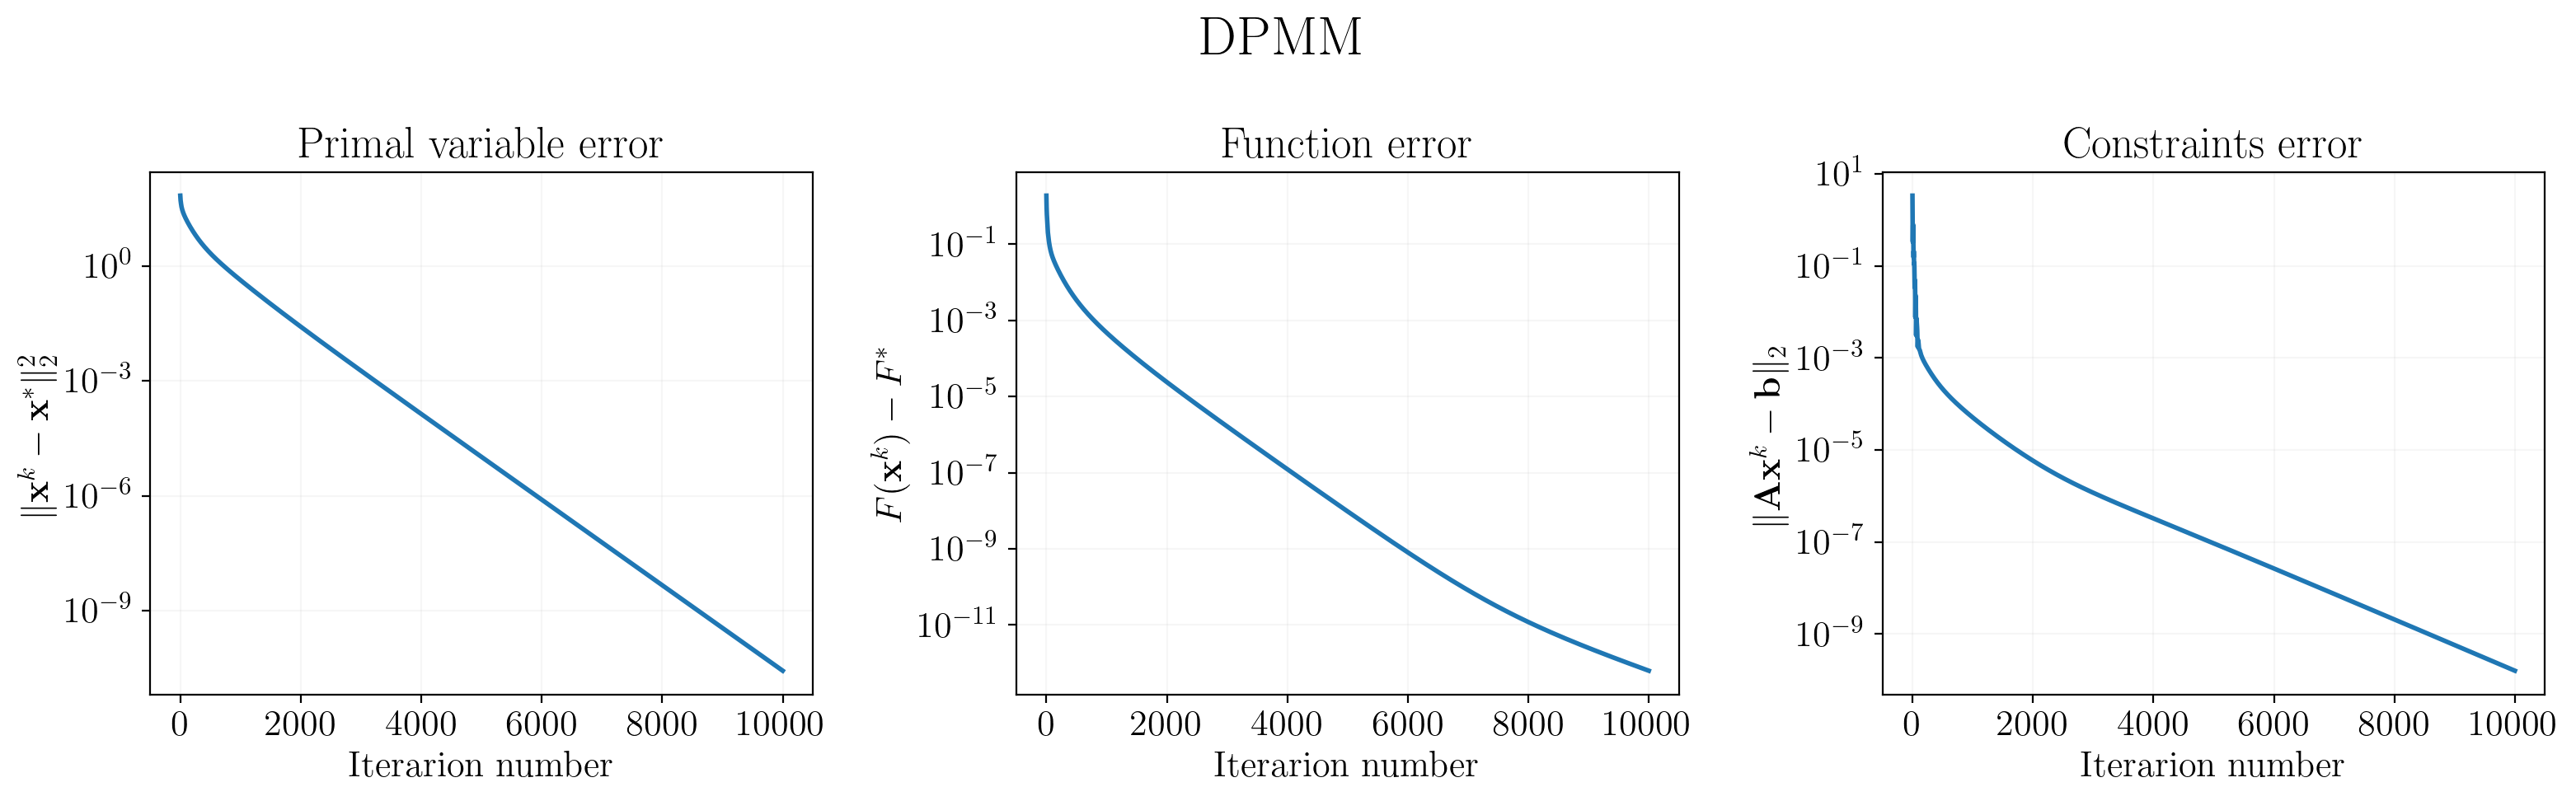

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(x_err)
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")

ax[1].plot(F_err)
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$F(\mathbf{x}^k) - F^*$")
ax[1].set_title("Function error")

ax[2].plot(cons_err)
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A} \mathbf{x}^k - \mathbf{b} \|_2$")
ax[2].set_title("Constraints error")

plt.suptitle("DPMM", fontsize=24)
plt.tight_layout()
plt.show()

## Comparison

Let's compare diffirent methods. For our method we check $|\tilde{F}(\mathbf{x}^k) - \tilde{F}^*|$, but for other methods we check $|F(\mathbf{x}^k) - F^*|$.

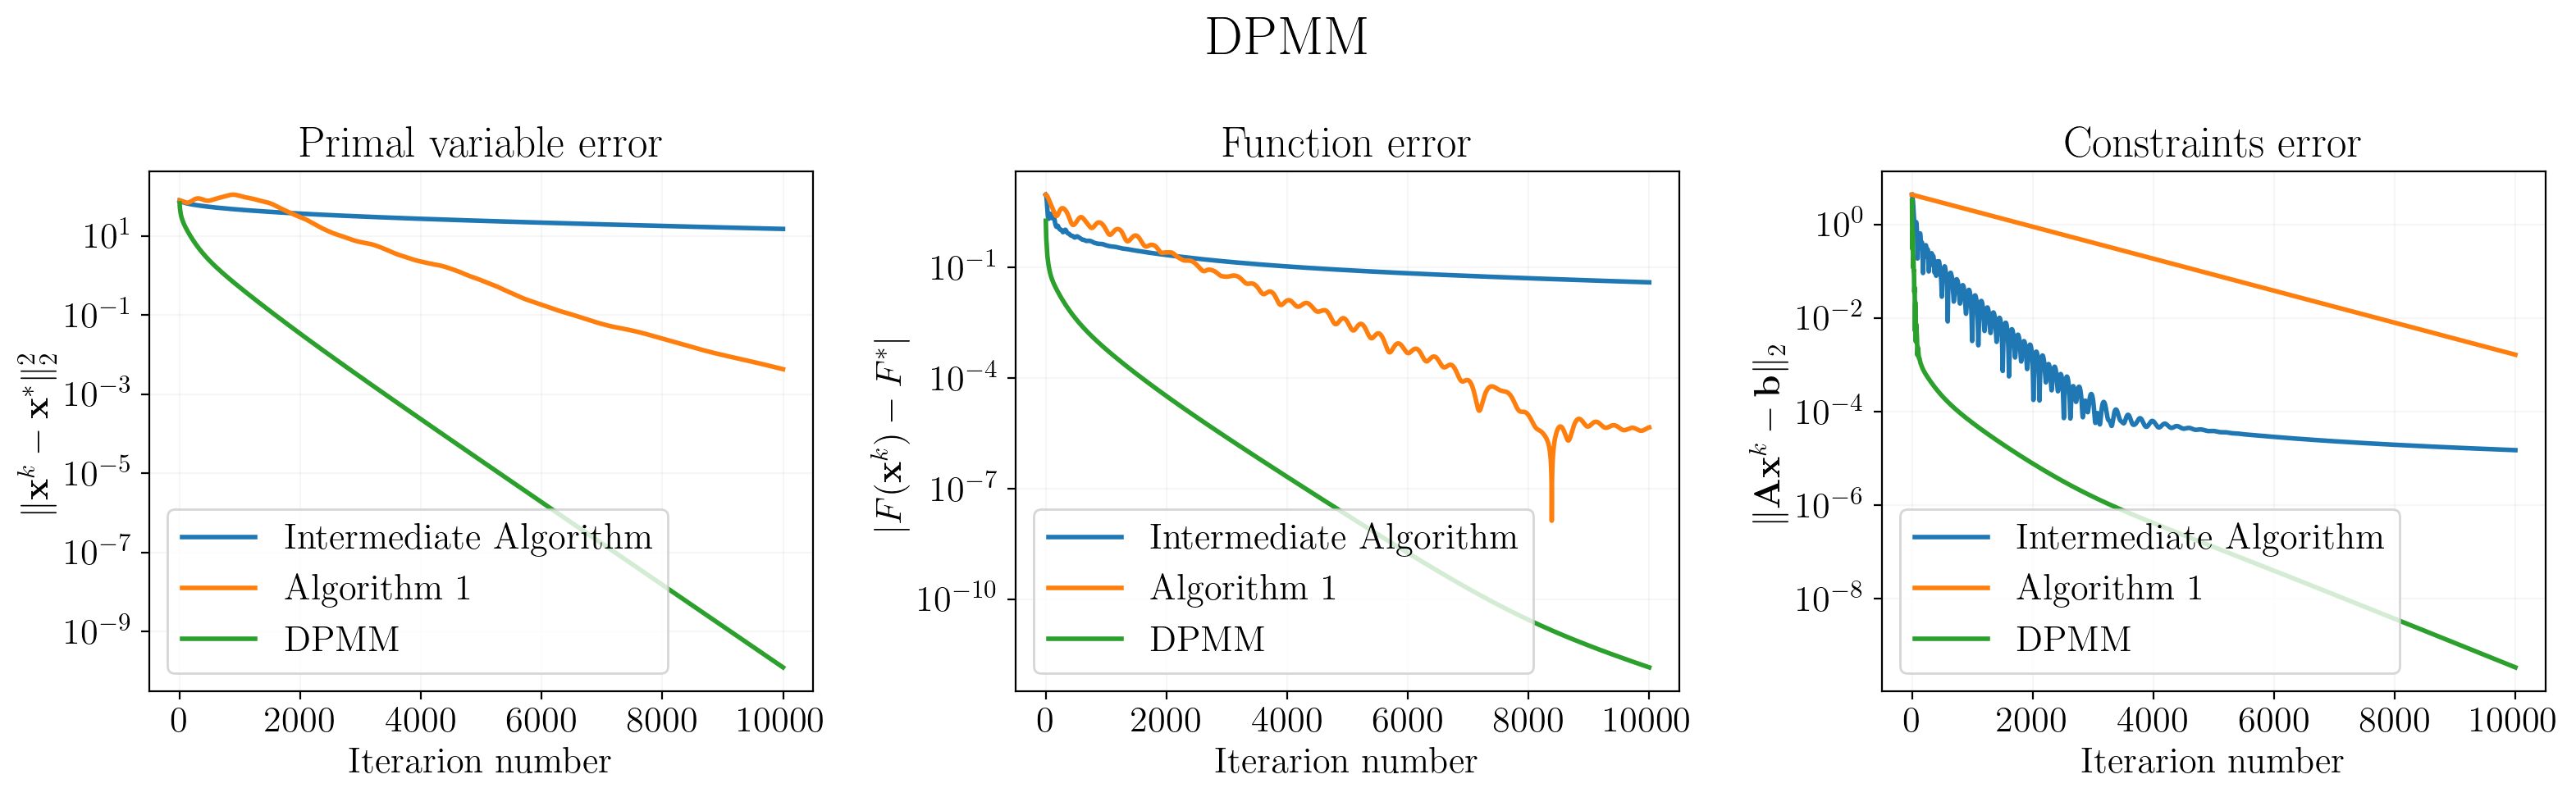

In [19]:
results = {"Intermediate Algorithm": {},
           "Algorithm 1": {},
           "DPMM": {}}

np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=False)

name = "Intermediate Algorithm"
_, x_err, F_err, cons_err, primal_dual_err = intermediate(num_steps=10**4, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err
results[name]['primal_dual_err'] = primal_dual_err

name = "Algorithm 1"
_, x_err, F_err, cons_err = salim(num_steps=10**4, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

name = "DPMM"
_, x_err, F_err, cons_err = DPMM(num_steps=10**4, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(results["Intermediate Algorithm"]['x_err'], label="Intermediate Algorithm")
ax[0].plot(results["Algorithm 1"]['x_err'], label="Algorithm 1")
ax[0].plot(results["DPMM"]['x_err'], label="DPMM")
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")
ax[0].legend()

ax[1].plot(results["Intermediate Algorithm"]['F_err'], label="Intermediate Algorithm")
ax[1].plot(results["Algorithm 1"]['F_err'], label="Algorithm 1")
ax[1].plot(results["DPMM"]['F_err'], label="DPMM")
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(\mathbf{x}^k) - F^*|$")
ax[1].set_title("Function error")
ax[1].legend()

ax[2].plot(results["Intermediate Algorithm"]['cons_err'], label="Intermediate Algorithm")
ax[2].plot(results["Algorithm 1"]['cons_err'], label="Algorithm 1")
ax[2].plot(results["DPMM"]['cons_err'], label="DPMM")
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A} \mathbf{x}^k - \mathbf{b} \|_2$")
ax[2].set_title("Constraints error")
ax[2].legend()

plt.suptitle("DPMM", fontsize=24)
plt.tight_layout()
plt.show()

Choose $W$ by Metropolis weights gossip matrix

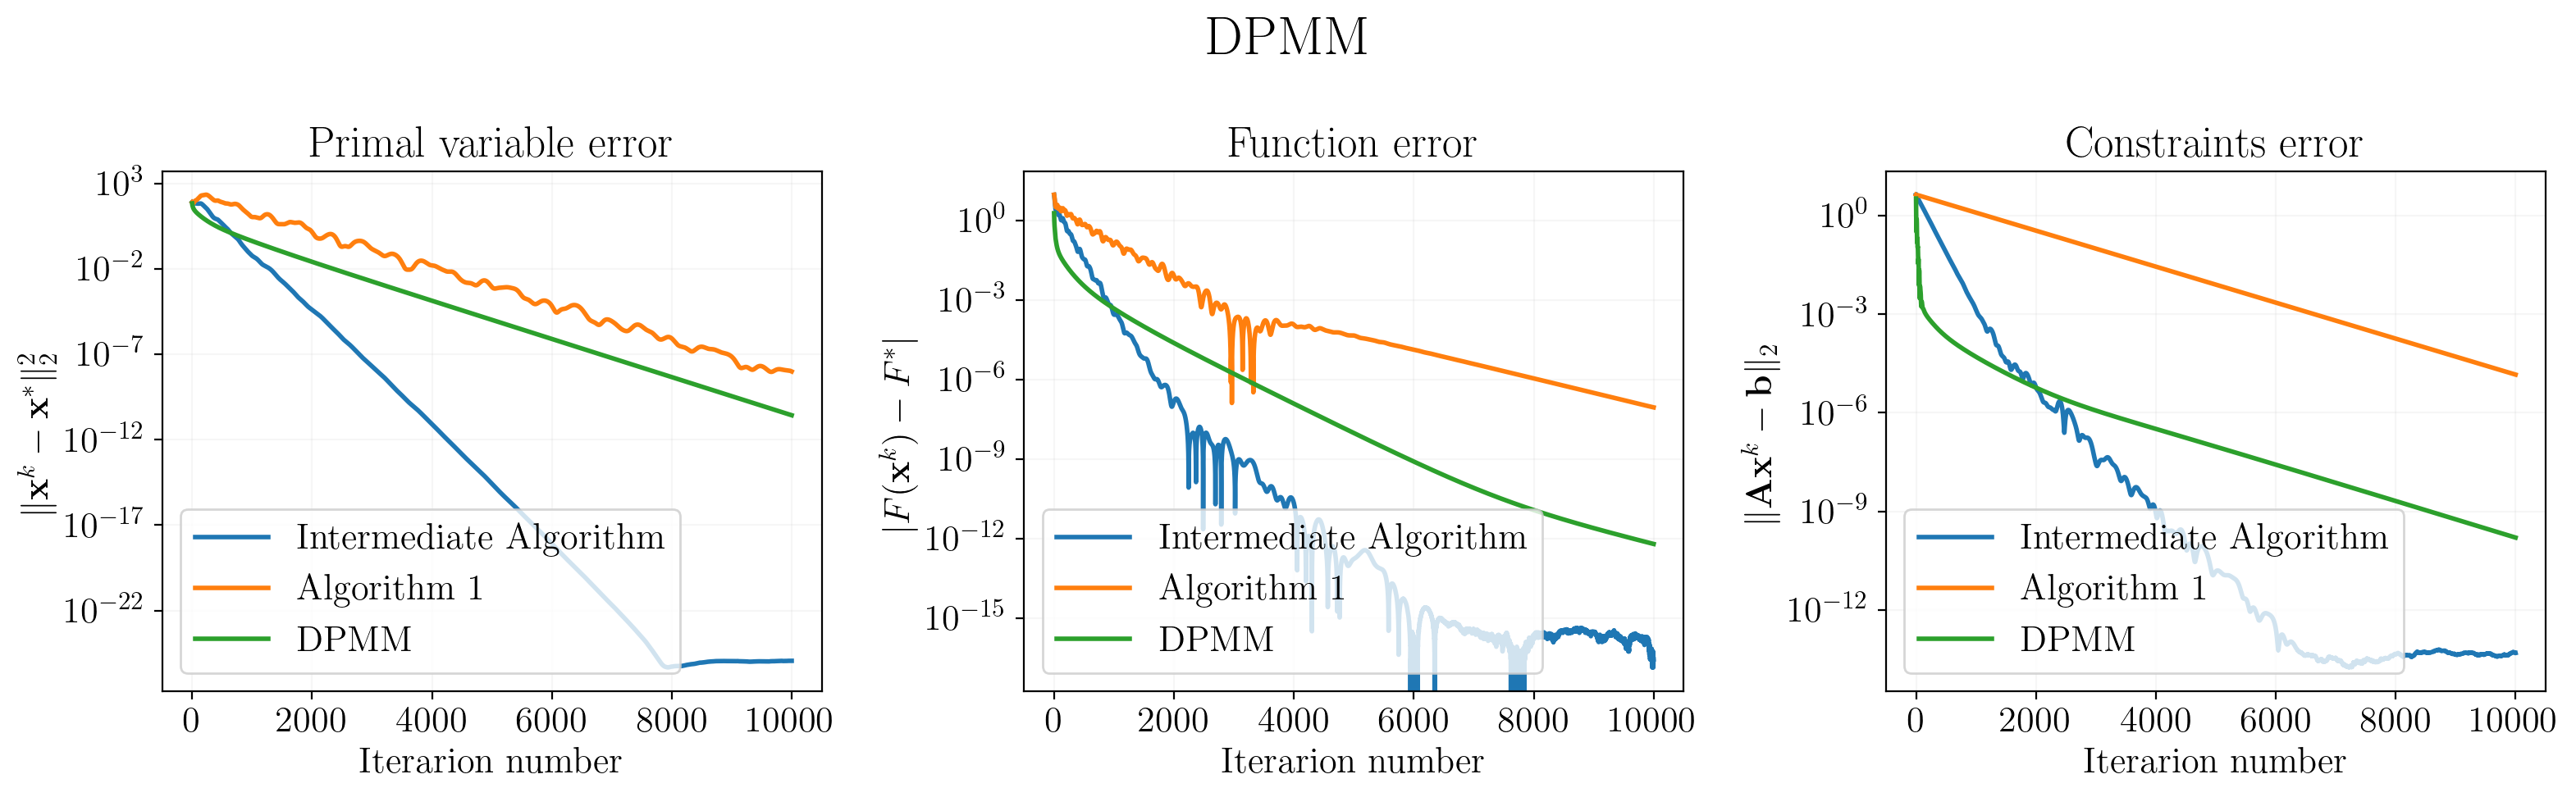

In [20]:
results = {"Intermediate Algorithm": {},
           "Algorithm 1": {},
           "DPMM": {}}

np.random.seed(307)
model = ExampleModel(num_nodes, num_cons, dims, graph, edge_prob=0.5, gossip=True)

name = "Intermediate Algorithm"
_, x_err, F_err, cons_err, primal_dual_err = intermediate(num_steps=10**4, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err
results[name]['primal_dual_err'] = primal_dual_err

name = "Algorithm 1"
_, x_err, F_err, cons_err = salim(num_steps=10**4, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

name = "DPMM"
_, x_err, F_err, cons_err = DPMM(num_steps=10**4, model=model)
results[name]['x_err'] = x_err
results[name]['F_err'] = F_err
results[name]['cons_err'] = cons_err

fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].plot(results["Intermediate Algorithm"]['x_err'], label="Intermediate Algorithm")
ax[0].plot(results["Algorithm 1"]['x_err'], label="Algorithm 1")
ax[0].plot(results["DPMM"]['x_err'], label="DPMM")
ax[0].set_yscale('log')
ax[0].set_xlabel("Iterarion number")
ax[0].set_ylabel(r"$\| \mathbf{x}^k - \mathbf{x}^* \|_2^2$")
ax[0].set_title("Primal variable error")
ax[0].legend()

ax[1].plot(results["Intermediate Algorithm"]['F_err'], label="Intermediate Algorithm")
ax[1].plot(results["Algorithm 1"]['F_err'], label="Algorithm 1")
ax[1].plot(results["DPMM"]['F_err'], label="DPMM")
ax[1].set_yscale('log')
ax[1].set_xlabel("Iterarion number")
ax[1].set_ylabel(r"$|F(\mathbf{x}^k) - F^*|$")
ax[1].set_title("Function error")
ax[1].legend()

ax[2].plot(results["Intermediate Algorithm"]['cons_err'], label="Intermediate Algorithm")
ax[2].plot(results["Algorithm 1"]['cons_err'], label="Algorithm 1")
ax[2].plot(results["DPMM"]['cons_err'], label="DPMM")
ax[2].set_yscale('log')
ax[2].set_xlabel("Iterarion number")
ax[2].set_ylabel(r"$\| \mathbf{A} \mathbf{x}^k - \mathbf{b} \|_2$")
ax[2].set_title("Constraints error")
ax[2].legend()

plt.suptitle("DPMM", fontsize=24)
plt.tight_layout()
plt.show()